In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

from scipy.optimize import minimize
from scipy.stats import norm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

import requests
import json
import time
import os
import yfinance as yf

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("="*80)
print("ATTF Checkpoint B")
print("="*80)
print("\nAll packages imported successfully")

ATTF Checkpoint B

All packages imported successfully


In [2]:
from dotenv import load_dotenv
load_dotenv('PolygonAPI.env')
POLYGON_API_KEY = os.getenv("POLYGON_API_KEY", "")
print(f"\n API Key loaded: {POLYGON_API_KEY[:10]}..." if POLYGON_API_KEY else "No API key")


 API Key loaded: i0mFBg4ssj...


In [3]:
ALL_TICKERS = {
    'AI Infrastructure': ['NVDA', 'AMD', 'MSFT', 'QCOM', 'CORW', 'NBIS', 'ORCL'],
    'Robotics and Space': ['TSLA', 'JOBY', 'RKLB', 'ASTS', 'BA'],
    'Cryptocurrencies': ['IREN', 'CORZ', 'IBIT', 'COIN', 'CLSK'],
    'Quantum': ['IONQ', 'RGTI', 'IBM', 'GOOG', 'HON']
}

FLAT_TICKERS = [t for sleeve in ALL_TICKERS.values() for t in sleeve]

START_DATE = '2015-01-01'
END_DATE = '2025-10-11'
INITIAL_CAPITAL = 100000

CHECKPOINT_A_SLEEVE_WEIGHTS = {
    'AI Infrastructure': 0.40,
    'Robotics and Space': 0.30,
    'Cryptocurrencies': 0.20,
    'Quantum': 0.10
}

ANNUAL_MGMT_FEE = 0.015
TRANSACTION_COST_BPS = 15
RISK_FREE_RATE = 0.04

print(f"\n Portfolio configuration:")
print(f"Total stocks: {len(FLAT_TICKERS)}")
for sleeve_name, tickers in ALL_TICKERS.items():
    print(f" {sleeve_name} ({len(tickers)}): {', '.join(tickers)}")


 Portfolio configuration:
Total stocks: 22
 AI Infrastructure (7): NVDA, AMD, MSFT, QCOM, CORW, NBIS, ORCL
 Robotics and Space (5): TSLA, JOBY, RKLB, ASTS, BA
 Cryptocurrencies (5): IREN, CORZ, IBIT, COIN, CLSK
 Quantum (5): IONQ, RGTI, IBM, GOOG, HON


In [4]:
print("\n" + "="*80)
print("Proxy Configuration for Extended Backtest")
print("="*80)

SLEEVE_PROXIES = {
    'AI Infrastructure': ['QQQ'],
    'Robotics and Space': ['ITA'],
    'Cryptocurrencies': ['BTC-USD'],
    'Quantum': ['XLK']
}

PROXY_START = '1999-01-01'

print(f"\nProxy tickers for long-history analysis:")
for sleeve, proxies in SLEEVE_PROXIES.items():
    print(f" {sleeve}: {', '.join(proxies)}")
print(f"\nProxy start date: {PROXY_START}")


Proxy Configuration for Extended Backtest

Proxy tickers for long-history analysis:
 AI Infrastructure: QQQ
 Robotics and Space: ITA
 Cryptocurrencies: BTC-USD
 Quantum: XLK

Proxy start date: 1999-01-01


In [5]:
SLEEVE_MAP = {}
for sleeve_name, tickers in ALL_TICKERS.items():
    for ticker in tickers:
        SLEEVE_MAP[ticker] = sleeve_name

print(f"\nCreated sleeve map for {len(SLEEVE_MAP)} tickers")


Created sleeve map for 22 tickers


In [6]:
def fetch_polygon_dividends(ticker, start_date, end_date, api_key):
    url = f"https://api.polygon.io/v3/reference/dividends"

    params = {
        'ticker': ticker,
        'ex_dividend_date.gte': start_date,
        'ex_dividend_date.lte': end_date,
        'limit': 1000,
        'apiKey': api_key
    }

    try:
        response = requests.get(url, params=params)
        data = response.json()

        if 'results' not in data or len(data['results']) == 0:
            return None

        df = pd.DataFrame(data['results'])
        df['date'] = pd.to_datetime(df['ex_dividend_date'])
        df = df[['date', 'cash_amount']]
        df = df.set_index('date')
        df.columns = ['dividend']

        return df

    except Exception as e:
        return None

In [7]:
def fetch_polygon_data_with_dividends(ticker, start_date, end_date, api_key):
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{start_date}/{end_date}"
    params = {
        'adjusted': 'true',
        'sort': 'asc',
        'limit': 50000,
        'apiKey': api_key
    }
    
    try:
        response = requests.get(url, params=params)
        data = response.json()
        
        if 'results' not in data:
            print(f"[{ticker}] No data available")
            return None

        df = pd.DataFrame(data['results'])
        df['date'] = pd.to_datetime(df['t'], unit='ms')
        df = df.set_index('date')[['c']]
        df.columns = ['price']

        div_df = fetch_polygon_dividends(ticker, start_date, end_date, api_key)
        
        if div_df is not None and len(div_df) > 0:
            df = df.join(div_df, how='left')
            df['dividend'] = df['dividend'].fillna(0)
            df['adj_price'] = df['price'].copy()
            
            for div_date in div_df.index:
                if div_date in df.index:
                    div_amount = div_df.loc[div_date, 'dividend']
                    price_at_div = df.loc[div_date, 'price']
                    adj_factor = 1 + (div_amount / price_at_div)
                    mask = df.index > div_date
                    df.loc[mask, 'adj_price'] *= adj_factor
            
            print(f"[{ticker}] {len(df)} days | {len(div_df)} dividends")
            return df[['adj_price']].rename(columns={'adj_price': ticker})
        else:
            print(f"[{ticker}] {len(df)} days | No dividends")
            return df[['price']].rename(columns={'price': ticker})
            
    except Exception as e:
        print(f"[{ticker}] Error: {str(e)}")
        return None

print("\n" + "="*80)
print("Downloading Dividend-Adjusted Data")
print("="*80 + "\n")

data_dict = {}

for ticker in FLAT_TICKERS:
    series = fetch_polygon_data_with_dividends(ticker, START_DATE, END_DATE, POLYGON_API_KEY)
    if series is not None:
        data_dict[ticker] = series
    time.sleep(0.15)



[NVDA] 2502 days | 43 dividends
[AMD] 2502 days | No dividends
[MSFT] 2502 days | 43 dividends
[QCOM] 2502 days | 43 dividends
[CORW] No data available
[NBIS] 244 days | No dividends
[ORCL] 2502 days | 44 dividends
[TSLA] 2502 days | No dividends
[JOBY] 1047 days | No dividends
[RKLB] 1037 days | No dividends
[ASTS] 1135 days | No dividends
[BA] 2502 days | 21 dividends
[IREN] 978 days | No dividends
[CORZ] 670 days | No dividends
[IBIT] 601 days | No dividends
[COIN] 1130 days | No dividends
[CLSK] 1436 days | No dividends
[IONQ] 1011 days | No dividends
[RGTI] 907 days | No dividends
[IBM] 2502 days | 43 dividends
[GOOG] 2502 days | 6 dividends
[HON] 2502 days | 43 dividends


In [8]:
print("\n" + "="*80)
print("Downloading SPY Benchmark")
print("="*80 + "\n")

spy_data = fetch_polygon_data_with_dividends('SPY', START_DATE, END_DATE, POLYGON_API_KEY)
if spy_data is not None:
    data_dict['SPY'] = spy_data

if len(data_dict) > 0:
    data_all = pd.concat([data_dict[ticker] for ticker in data_dict.keys()], 
                         axis=1, 
                         keys=data_dict.keys())
else:
    print("No data was downloaded!")
    data_all = pd.DataFrame()

print(f"\n{'='*80}")
print(f"DATA LOADED (DIVIDEND-ADJUSTED)")
print(f"{'='*80}")
print(f"Portfolio stocks: {len([c for c in data_all.columns if c != 'SPY'])}/{len(FLAT_TICKERS)}")
print(f"Benchmark: SPY")
print(f"Date range: {data_all.index[0].date()} to {data_all.index[-1].date()}")
print(f"Shape: {data_all.shape}")

missing = [t for t in FLAT_TICKERS if t not in data_all.columns]
if missing:
    print(f"\n Missing tickers: {', '.join(missing)}")
    print("These will be excluded from analysis.")

data_all = data_all.fillna(method='ffill').fillna(method='bfill')
min_stocks_required = len(data_all.columns) * 0.5
data_all = data_all.dropna(thresh=min_stocks_required)

print(f"\n After cleaning: {data_all.shape[0]} days with {data_all.shape[1]} assets")

spy_prices = data_all[['SPY']].copy()
data = data_all.drop('SPY', axis=1)



[SPY] 2502 days | 43 dividends

DATA LOADED (DIVIDEND-ADJUSTED)
Portfolio stocks: 22/22
Benchmark: SPY
Date range: 2015-10-29 to 2025-10-10
Shape: (2502, 22)

 Missing tickers: CORW
These will be excluded from analysis.

 After cleaning: 2502 days with 22 assets


In [9]:
print("\n" + "="*80)
print("Downloading Proxy Data (1999-Present)")
print("="*80 + "\n")

def load_proxy_prices(tickers, start=PROXY_START, end=END_DATE):
    try:
        px = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)['Close']
        if isinstance(px, pd.Series):
            px = px.to_frame(tickers[0])
        px = px.dropna(how='all').ffill()
        return px
    except Exception as e:
        print(f"Error downloading {tickers}: {e}")
        return pd.DataFrame()

proxy_data = {}
for sleeve_name, tickers in SLEEVE_PROXIES.items():
    print(f"[{sleeve_name}] Downloading {', '.join(tickers)}...")
    px = load_proxy_prices(tickers, start=PROXY_START, end=END_DATE)
    if not px.empty:
        proxy_data[sleeve_name] = px.mean(axis=1)
        print(f" {len(px)} days")
    else:
        print(f"No data")

proxy_prices = pd.DataFrame(proxy_data).dropna(how='all')

print(f"\nProxy data loaded: {proxy_prices.shape[0]} days, {proxy_prices.shape[1]} sleeves")
print(f"Date range: {proxy_prices.index[0].date()} to {proxy_prices.index[-1].date()}")



[AI Infrastructure] Downloading QQQ...
 6690 days
[Robotics and Space] Downloading ITA...
 4890 days
[Cryptocurrencies] Downloading BTC-USD...
 4042 days
[Quantum] Downloading XLK...
 6735 days

Proxy data loaded: 7993 days, 4 sleeves
Date range: 1999-01-04 to 2025-10-10


In [10]:
print("\n" + "="*80)
print("Performance Helpers")
print("="*80)

TRADING_DAYS = 252

def ann_return(log_ret):
    n_days = len(log_ret)
    years = n_days / TRADING_DAYS

    total_log_return = log_ret.sum()

    total_return = np.exp(total_log_return) - 1

    cagr = (1 + total_return) ** (1 / years) - 1

    return cagr

def ann_vol(log_ret):
    return log_ret.std() * np.sqrt(TRADING_DAYS)

def sharpe_ratio(log_ret, rf_annual=RISK_FREE_RATE):
    rf_daily = rf_annual / TRADING_DAYS
    excess_ret = (log_ret.mean() - rf_daily) * TRADING_DAYS
    vol = ann_vol(log_ret)
    return excess_ret / vol if vol > 0 else 0.0

def alpha_beta_calc(port_log_ret, bench_log_ret):
    aligned = pd.concat([port_log_ret, bench_log_ret], axis=1).dropna()
    if len(aligned) < 2:
        return np.nan, np.nan

    port = aligned.iloc[:, 0].values
    bench = aligned.iloc[:, 1].values
    cov_matrix = np.cov(port, bench)
    beta = cov_matrix[0, 1] / cov_matrix[1, 1]

    alpha = (np.mean(port) - beta * np.mean(bench)) * TRADING_DAYS

    return alpha, beta

def max_drawdown(log_ret):
    cum_ret = log_ret.cumsum()
    wealth = np.exp(cum_ret)
    running_max = wealth.cummax()
    drawdown = (wealth / running_max - 1.0)
    return drawdown.min()

print("Performance helpers defined")


Performance Helpers
Performance helpers defined


In [11]:
print("\n" + "="*80)
print("Calculating Log Returns")
print("="*80)

returns = np.log(data / data.shift(1)).dropna()
print(f"\nPortfolio log returns: {returns.shape}")

spy_returns = np.log(spy_prices / spy_prices.shift(1)).dropna()
print(f"SPY log returns: {spy_returns.shape}")

proxy_returns = np.log(proxy_prices /proxy_prices.shift(1)).dropna()
print(f"Proxy log returns: {proxy_returns.shape}")


Calculating Log Returns

Portfolio log returns: (2501, 21)
SPY log returns: (2501, 1)
Proxy log returns: (2178, 4)


In [12]:
print("\n" + "="*80)
print("Calculating Sleeve Returns")
print("="*80)

sleeve_returns = pd.DataFrame()

for sleeve_name, tickers in ALL_TICKERS.items():
    available_tickers = [t for t in tickers if t in returns.columns]
    
    if len(available_tickers) == 0:
        print(f"\n {sleeve_name}: No data available")
        continue

    sleeve_returns[sleeve_name] = returns[available_tickers].mean(axis=1)

    missing_in_sleeve = set(tickers) - set(available_tickers)
    if missing_in_sleeve:
        print(f"\n{sleeve_name}:")
        print(f"  Available: {', '.join(available_tickers)}")
        print(f"  Missing: {', '.join(missing_in_sleeve)}")
    else:
        print(f"\n{sleeve_name}: All {len(tickers)} stocks available")

print(f"\nCalculated sleeve returns for {len(sleeve_returns.columns)} sleeves")
print(f"  Shape: {sleeve_returns.shape}")


Calculating Sleeve Returns

AI Infrastructure:
  Available: NVDA, AMD, MSFT, QCOM, NBIS, ORCL
  Missing: CORW

Robotics and Space: All 5 stocks available

Cryptocurrencies: All 5 stocks available

Quantum: All 5 stocks available

Calculated sleeve returns for 4 sleeves
  Shape: (2501, 4)


In [13]:
print("\n" + "="*80)
print("Proxy Sleeve Returns (1999-PRESENT)")
print("="*80)

print(f"\nProxy sleeve performance (annualized):")
for sleeve in proxy_returns.columns:
    ret = ann_return(proxy_returns[sleeve])
    vol = ann_vol(proxy_returns[sleeve])
    sr = sharpe_ratio(proxy_returns[sleeve])
    print(f"  {sleeve}:")
    print(f"    Return: {ret:.2%}, Vol: {vol:.2%}, Sharpe: {sr:.3f}")


Proxy Sleeve Returns (1999-PRESENT)

Proxy sleeve performance (annualized):
  AI Infrastructure:
    Return: 17.67%, Vol: 21.78%, Sharpe: 0.563
  Robotics and Space:
    Return: 16.53%, Vol: 21.53%, Sharpe: 0.525
  Cryptocurrencies:
    Return: 28.21%, Vol: 61.23%, Sharpe: 0.341
  Quantum:
    Return: 21.76%, Vol: 23.38%, Sharpe: 0.671


In [80]:
print("\n" + "="*80)
print("Monte Carlo Portfolio Optimization: LONG-ONLY vs SHORTS-ALLOWED")
print("="*80)

N_SIMULATIONS = 10000
ANNUAL_MGMT_FEE = 0.015
TRANSACTION_COST_BPS = 15

opt_returns = sleeve_returns.copy()

print(f"\nRunning {N_SIMULATIONS:,} simulations for EACH scenario...")
print(f"Management fee: {ANNUAL_MGMT_FEE*100}%")
print(f"Transaction costs: {TRANSACTION_COST_BPS} bps")

mean_returns = pd.Series({
    sleeve: ann_return(opt_returns[sleeve])
    for sleeve in opt_returns.columns
})
cov_matrix = opt_returns.cov() * TRADING_DAYS

print("\m" + "="*60)
print("SCENARIO 1: LONG-ONLY PORTFOLIOS")
print("="*60)

results_long = np.zeros((3, N_SIMULATIONS))
weights_long = np.zeros((N_SIMULATIONS, len(opt_returns.columns)))

np.random.seed(42)

for i in range(N_SIMULATIONS):
    w = np.random.random(len(opt_returns.columns))
    w /= w.sum()

    port_return = np.sum(mean_returns * w)
    port_vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))

    net_return = port_return - ANNUAL_MGMT_FEE - (TRANSACTION_COST_BPS / 10000)
    sharpe = (net_return - RISK_FREE_RATE) / port_vol if port_vol > 0 else 0.0

    results_long[0, i] = net_return
    results_long[1, i] = port_vol
    results_long[2, i] = sharpe
    weights_long[i, :] = w

mc_long = pd.DataFrame({
    'Return': results_long[0],
    'Volatility': results_long[1],
    'Sharpe': results_long[2]
})

max_sharpe_long_idx = mc_long['Sharpe'].idxmax()
min_vol_long_idx = mc_long['Volatility'].idxmax()

optimal_weights_long = pd.Series(weights_long[max_sharpe_long_idx],
                                 index=opt_returns.columns)
min_vol_weights_long = pd.Series(weights_long[min_vol_long_idx],
                                 index=opt_returns.columns)

print(f"\nOptimal Portfolio (Max Sharpe - Long Only):")
print(f" Return: {mc_long.loc[max_sharpe_long_idx, 'Return']:.2%}")
print(f" Volatility: {mc_long.loc[max_sharpe_long_idx, 'Volatility']:.2%}")
print(f" Sharpe: {mc_long.loc[max_sharpe_long_idx, 'Sharpe']:.3f}")
print(f"\n Weights:")
for sleeve, weight in optimal_weights_long.items():
    print(f" {sleeve}: {weight:>6.1%}")

print("\n" + "="*60)
print("Scenario2: SHORTS-ALLOWED PORTFOLIOS")
print(f"="*60)

results_short = np.zeros((3, N_SIMULATIONS))
weights_short = np.zeros((N_SIMULATIONS, len(opt_returns.columns)))

np.random.seed(42)

for i in range(N_SIMULATIONS):
    w = np.random.uniform(-1, 1, len(opt_returns.columns) - 1)
    last_weight = 1 - np.sum(w)
    w = np.append(w, last_weight)

    port_return = np.sum(mean_returns * w)
    port_vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))

    net_return = port_return - ANNUAL_MGMT_FEE - (TRANSACTION_COST_BPS / 10000)
    sharpe = (net_return - RISK_FREE_RATE) / port_vol if port_vol > 0 else 0.0

    results_short[0, i] = net_return
    results_short[1, i] = port_vol
    results_short[2, i] = sharpe
    weights_short[i, :] = w

mc_short = pd.DataFrame({
    'Return': results_short[0],
    'Volatility': results_short[1],
    'Sharpe': results_short[2]
})

max_sharpe_short_idx = mc_short['Sharpe'].idxmax()
min_vol_short_idx = mc_short['Volatility'].idxmin()

optimal_weights_short = pd.Series(weights_short[max_sharpe_short_idx],
                                  index=opt_returns.columns)
min_vol_weights_short = pd.Series(weights_short[min_vol_short_idx],
                                  index=opt_returns.columns)

print(f"\nOptimal Portfolio (Max Sharpe - Shorts Allowed):")
print(f" Return: {mc_short.loc[max_sharpe_short_idx, 'Return']:.2%}")
print(f" Volatility: {mc_short.loc[max_sharpe_short_idx, 'Volatility']:.2%}")
print(f" Sharpe: {mc_short.loc[max_sharpe_short_idx, 'Sharpe']:.3f}")
print(f" Gross Leverage: {np.abs(optimal_weights_short).sum():.2f}x")
print(f"\n Weights:")
for sleeve, weight in optimal_weights_short.items():
    sign = "LONG" if weight > 0 else "SHORT"
    print(f" {sleeve}: {weight:>7.1%} ({sign})")

print("\n" + "="*80)
print("Comparison: LONG-ONLY vs SHORTS-ALLOWED")
print("="*80)

checkpoint_a_returns = opt_returns @ pd.Series(CHECKPOINT_A_SLEEVE_WEIGHTS)
checkpoint_a_perf = {
    'Return': ann_return(checkpoint_a_returns),
    'Volatility': ann_vol(checkpoint_a_returns),
    'Sharpe': sharpe_ratio(checkpoint_a_returns)
}

comparison = pd.DataFrame({
    'Checkpoint A (40/30/20/10)': [
        checkpoint_a_perf['Return'],
        checkpoint_a_perf['Volatility'],
        checkpoint_a_perf['Sharpe']
    ],
    'MC Long-Only (Optimal)': [
        mc_long.loc[max_sharpe_long_idx, 'Return'],
        mc_long.loc[max_sharpe_long_idx, 'Volatility'],
        mc_long.loc[max_sharpe_long_idx, 'Sharpe']
    ],
    'MC Shorts-Allowed (Optimal)': [
        mc_short.loc[max_sharpe_short_idx, 'Return'],
        mc_short.loc[max_sharpe_short_idx, 'Volatility'],
        mc_short.loc[max_sharpe_short_idx, 'Sharpe']
    ]
}, index=['Return', 'Volatility', 'Sharpe'])

print(f"\n{comparison.to_string()}\n")

long_improvement = mc_long.loc[max_sharpe_long_idx, 'Return'] - checkpoint_a_perf['Return']
short_improvement = mc_short.loc[max_sharpe_short_idx, 'Return'] - checkpoint_a_perf['Return']

print(f"Key Insights:")
print(f" Long-only optimization improved returns by: {long_improvement:+.2%}")
print(f" Shorts-allowed optimization improved returns by: {short_improvement:+.2%}")
print(f" Shorts-allowed vs Long-only gain: {(short_improvement - long_improvement):+.2%}")


Monte Carlo Portfolio Optimization: LONG-ONLY vs SHORTS-ALLOWED

Running 10,000 simulations for EACH scenario...
Management fee: 1.5%
Transaction costs: 15 bps
\m============================================================
SCENARIO 1: LONG-ONLY PORTFOLIOS

Optimal Portfolio (Max Sharpe - Long Only):
 Return: 30.51%
 Volatility: 27.32%
 Sharpe: 0.970

 Weights:
 AI Infrastructure:  92.4%
 Robotics and Space:   2.0%
 Cryptocurrencies:   1.9%
 Quantum:   3.7%

Scenario2: SHORTS-ALLOWED PORTFOLIOS

Optimal Portfolio (Max Sharpe - Shorts Allowed):
 Return: 32.30%
 Volatility: 28.25%
 Sharpe: 1.002
 Gross Leverage: 1.15x

 Weights:
 AI Infrastructure:   98.8% (LONG)
 Robotics and Space:    8.7% (LONG)
 Cryptocurrencies:   -5.3% (SHORT)
 Quantum:   -2.2% (SHORT)

Comparison: LONG-ONLY vs SHORTS-ALLOWED

            Checkpoint A (40/30/20/10)  MC Long-Only (Optimal)  MC Shorts-Allowed (Optimal)
Return                        0.212464                0.305062                     0.322955
Volatil

In [15]:
print("\n" + "="*80)
print(" Clenow Momentum Strategy")
print("="*80)

MOMENTUM_LOOKBACK = 90
MA_FILTER = 200
TOP_N_STOCKS = 10

print(f"\nStrategy paramters:")
print(f" Momentum lookback: {MOMENTUM_LOOKBACK} days")
print(f" MA filter: {MA_FILTER} days")
print(f" Portfolio size: Top {TOP_N_STOCKS} stocks")

initial_prices = pd.Series(100, index=returns.columns)
prices = (1 + returns).cumprod() * initial_prices

all_momentum = prices.pct_change(MOMENTUM_LOOKBACK)
all_ma = prices.rolling(MA_FILTER).mean()
all_above_ma = prices > all_ma

month_groups = prices.groupby(prices.index.to_period('M'))
month_end_dates = month_groups.apply(lambda x: x.index[-1])

print(f"\nGenerating signals for {len(month_end_dates)} months...")

clenow_signals = pd.DataFrame(0, index=month_end_dates, columns=prices.columns)

for date in month_end_dates:
    mom_at_date = all_momentum.loc[date]
    ma_pass_at_date = all_above_ma.loc[date]

    valid_stocks = mom_at_date[ma_pass_at_date].dropna()

    if len(valid_stocks) == 0:
        continue

    n_to_select = min(TOP_N_STOCKS, len(valid_stocks))
    top_stocks = valid_stocks.nlargest(n_to_select).index
    clenow_signals.loc[date, top_stocks] = 1

signals_count = clenow_signals.sum(axis=1).mean()
print(f"\n Signals generated: {len(clenow_signals)} months")
print(f" Average stocks held: {signals_count:.1f}")

clenow_signals_daily = (
    clenow_signals
    .sort_index()
    .reindex(returns.index, method='ffill')
    .shift(1)
    .fillna(0)
    .astype(int)
)

print(f" Daily signals aligned: {clenow_signals_daily.shape[0]} days")


 Clenow Momentum Strategy

Strategy paramters:
 Momentum lookback: 90 days
 MA filter: 200 days
 Portfolio size: Top 10 stocks

Generating signals for 121 months...

 Signals generated: 121 months
 Average stocks held: 6.6
 Daily signals aligned: 2501 days


In [16]:
print("\n" + "="*80)
print(" Running Clenow Momentum Backtest")
print("="*80)

n_holdings = clenow_signals_daily.sum(axis=1).replace(0, np.nan)
clenow_weights = clenow_signals_daily.div(n_holdings, axis=0).fillna(0)

clenow_returns = (returns * clenow_weights).sum(axis=1)

non_zero_days = (clenow_returns != 0).sum()
print(f" Non-zero return days: {non_zero_days}/{len(clenow_returns)}")

clenow_metrics = {
    'CAGR': ann_return(clenow_returns),
    'Volatility': ann_vol(clenow_returns),
    'Sharpe': sharpe_ratio(clenow_returns),
    'Max Drawdown': max_drawdown(clenow_returns)
}

clenow_alpha, clenow_beta = alpha_beta_calc(clenow_returns, spy_returns)

print("\n Clenow Momentum Results:")
print(f" CAGR: {clenow_metrics['CAGR']:.2%}")
print(f" Volatility: {clenow_metrics['Volatility']:.2%}")
print(f" Sharpe Ratio: {clenow_metrics['Sharpe']:.3f}")
print(f" Max Drawdown: {clenow_metrics['Max Drawdown']:.2%}")
print(f" Alpha: {clenow_alpha:.4f}")
print(f" Beta: {clenow_beta:.3f}")

bnh_returns = returns.mean(axis=1)
bnh_metrics = {
    'CAGR': ann_return(bnh_returns),
    'Volatility': ann_vol(bnh_returns),
    'Sharpe': sharpe_ratio(bnh_returns),
    'Max Drawdown': max_drawdown(bnh_returns)
}

print(f"\n Buy-and-Hold Comparison:")
print(f" CAGR: {bnh_metrics['CAGR']:.2%}")
print(f" Volatility: {bnh_metrics['Volatility']:.2%}")
print(f" Sharpe Ratio: {bnh_metrics['Sharpe']:.3f}")
print(f" Max Drawdown: {bnh_metrics['Max Drawdown']:.2%}")

checkpoint_a_return = sleeve_returns @ pd.Series(CHECKPOINT_A_SLEEVE_WEIGHTS)
checkpoint_a_cagr = ann_return(checkpoint_a_returns)
checkpoint_a_sharpe = sharpe_ratio(checkpoint_a_returns)

print(f"\n Checkpoint A (40/30/20/10):")
print(f" CAGR: {checkpoint_a_cagr:.2%}")
print(f" Sharpe Ratio: {checkpoint_a_sharpe:.3f}")

print(f"\n Strategy Comparisos:")
print(f" Clenow vs BNH: {clenow_metrics['CAGR'] - bnh_metrics['CAGR']:+.2%}")
print(f" Clenow vs Checkpoint A: {clenow_metrics['CAGR'] - checkpoint_a_cagr:+.2%}")


 Running Clenow Momentum Backtest
 Non-zero return days: 2246/2501

 Clenow Momentum Results:
 CAGR: 25.24%
 Volatility: 32.89%
 Sharpe Ratio: 0.563
 Max Drawdown: -72.95%
 Alpha: 0.0926
 Beta: 1.154

 Buy-and-Hold Comparison:
 CAGR: 18.78%
 Volatility: 27.44%
 Sharpe Ratio: 0.481
 Max Drawdown: -69.83%

 Checkpoint A (40/30/20/10):
 CAGR: 21.25%
 Sharpe Ratio: 0.564

 Strategy Comparisos:
 Clenow vs BNH: +6.46%
 Clenow vs Checkpoint A: +4.00%


In [17]:
print("\n" + "="*80)
print("Mean Reversion Strategy")
print("="*80)

LOOKBACK_WINDOW = 20
Z_SCORE_THRESHOLD = 1.0
REBALANCE_FREQ = 'W'
TOP_N_REVERSIONS = 10

print(f"\nStrategy parameters:")
print(f" Lookback window: {LOOKBACK_WINDOW} days")
print(f"  Z-score threshold: ±{Z_SCORE_THRESHOLD}")
print(f" Rebalance frequency: {REBALANCE_FREQ}")
print(f" Portfolio size: Top {TOP_N_REVERSIONS} stocks")

initial_prices = pd.Series(100, index=returns.columns)
prices = (1 + returns).cumprod() * initial_prices


rolling_mean = prices.rolling(LOOKBACK_WINDOW).mean()
rolling_std = prices.rolling(LOOKBACK_WINDOW).std()

z_scores = (prices - rolling_mean) / rolling_std

week_ends = prices.resample(REBALANCE_FREQ).last().index

mean_reversion_signals = pd.DataFrame(0, index=week_ends, columns=prices.columns)

for date in week_ends:
    if date not in z_scores.index:
        continue

    current_z = z_scores.loc[date]

    extreme_scores = current_z[(current_z < -Z_SCORE_THRESHOLD) | (current_z > Z_SCORE_THRESHOLD)].dropna()

    if len(extreme_scores) == 0:
        continue

    extreme_abs = extreme_scores.abs()
    n_to_select = min(TOP_N_REVERSIONS, len(extreme_abs))
    most_extreme = extreme_abs.nlargest(n_to_select).index

    mean_reversion_signals.loc[date, most_extreme] = 1

signals_count = mean_reversion_signals.sum(axis=1).mean()
print(f"\n Signals generated: {len(mean_reversion_signals)} weeks")
print(f" Average stocks held: {signals_count:.1f}")

if signals_count == 0:
    print("\n Warning: Still no signals! Tech stocks may be too trending.")
    print(" Mean reversion may not be suitable for this portfolio")
else:
    mean_reversion_signals_daily = (
        mean_reversion_signals
        .sort_index()
        .reindex(returns.index, method='ffill')
        .shift(1)
        .fillna(0)
        .astype(int)
    )

    print(f" Daily signals aligned: {mean_reversion_signals_daily.shape[0]} days")


Mean Reversion Strategy

Strategy parameters:
 Lookback window: 20 days
  Z-score threshold: ±1.0
 Rebalance frequency: W
 Portfolio size: Top 10 stocks

Calculating mean reversion signals...

 Signals generated: 520 weeks
 Average stocks held: 0.0

 Mean reversion may not be suitable for this portfolio


In [18]:
print("\n" + "="*80)
print("Machine Learning Walk-Forward Backtest)")
print("="*80)

TRAIN_WINDOW = 252 * 3
TEST_WINDOW = 21
MIN_TRAIN_SIZE = 252

print(f"\nML Paramters:")
print(f" Training window: {TRAIN_WINDOW} days ({TRAIN_WINDOW/252:.1f} years)")
print(f" Test window: {TEST_WINDOW} days")
print(f" Min training size: {MIN_TRAIN_SIZE} days")

print(f"\nBuilding feture matrix...")

initial_prices = pd.Series(100, index=returns.columns)
prices = (1 + returns).cumprod() * initial_prices

features_list = []

for ticker in returns.columns:
    ticker_features = pd.DataFrame(index=returns.index)

    ticker_features[f'{ticker}_mom_20'] = prices[ticker].pct_change(20)
    ticker_features[f'{ticker}_mom_60'] = prices[ticker].pct_change(60)
    ticker_features[f'{ticker}_mom_120'] = prices[ticker].pct_change(120)
    
    ticker_features[f'{ticker}_vol_20'] = returns[ticker].rolling(20).std()
    ticker_features[f'{ticker}_vol_60'] = returns[ticker].rolling(60).std()

    ma_20 = prices[ticker].rolling(20).mean()
    ma_60 = prices[ticker].rolling(60).mean()
    ticker_features[f'{ticker}_ma_ratio'] = ma_20 / ma_60
    
    features_list.append(ticker_features)

X = pd.concat(features_list, axis=1)

spy_prices = (1 + spy_returns).cumprod() * 100
X['spy_mom_20'] = spy_prices.pct_change(20)
X['spy_mom_60'] = spy_prices.pct_change(60)
X['spy_vol_20'] = spy_returns.rolling(20).std()

print(f" Feature matrix: {X.shape}")
print(f" Features per stock: 6")
print(f" Total features: {X.shape[1]}")

y = returns.shift(-TEST_WINDOW).rolling(TEST_WINDOW).sum()

print(f" Target matrix: {y.shape}")


Machine Learning Walk-Forward Backtest)

ML Paramters:
 Training window: 756 days (3.0 years)
 Test window: 21 days
 Min training size: 252 days

Building feture matrix...
 Feature matrix: (2501, 129)
 Features per stock: 6
 Total features: 129
 Target matrix: (2501, 21)


In [19]:
print("\n" + "="*80)
print(" Running ML Walk-Forward Backtest")
print("="*80)

ml_signals = pd.DataFrame(index=[], columns=returns.columns)

n_iterations = 0
start_idx = MIN_TRAIN_SIZE

print("Running walk-forward optimization...\n")

while start_idx + TRAIN_WINDOW + TEST_WINDOW < len(X):
    train_start = start_idx
    train_end = start_idx + TRAIN_WINDOW
    test_end = train_end + TEST_WINDOW

    X_train = X.iloc[train_start:train_end]
    y_train = y.iloc[train_start:train_end]

    valid_rows = X_train.notna().all(axis=1) & y_train.notna().all(axis=1)
    X_train = X_train[valid_rows]
    y_train = y_train[valid_rows]

    if len(X_train) < 100:
        start_idx += TEST_WINDOW
        continue

    test_date = X.index[train_end]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    predictions = {}

    for ticker in returns.columns:
        if ticker not in y_train.columns:
            continue

        model = Ridge(alpha=1.0)

        try:
            model.fit(X_train_scaled, y_train[ticker])
            
            X_test = X.loc[test_date:test_date]
            if X_test.notna().all(axis=1).any():
                X_test_scaled = scaler.transform(X_test)
                pred = model.predict(X_test_scaled)[0]
                predictions[ticker] = pred
        except:
            continue

    if len(predictions) > 0:
        pred_series = pd.Series(predictions)
        top_10 = pred_series.nlargest(10).index

        signal_row = pd.Series(0, index=returns.columns)
        signal_row[top_10] = 1

        ml_signals = pd.concat([ml_signals, signal_row.to_frame(test_date).T])

    start_idx += TEST_WINDOW
    n_iterations += 1

    if n_iterations % 10 == 0:
        print(f" Completed {n_iterations} iterations... (date: {test_date.date()})")

print(f"\n Walk-forward complete: {n_iterations} iterations")
print(f" Signals generated: {len(ml_signals)} periods")
print(f" Average stocks held: {ml_signals.sum(axis=1).mean():.1f}")

ml_signals_daily = (
    ml_signals
    .sort_index()
    .reindex(returns.index, method='ffill')
    .shift(1)
    .fillna(0)
    .astype(int)
)

print(f" Daily signals aligned: {ml_signals_daily.shape[0]} days")

non_zero_signals = (ml_signals_daily.sum(axis=1) > 0).sum()
print(f" Days with active positions: {non_zero_signals}/{len(ml_signals_daily)}")


 Running ML Walk-Forward Backtest
Running walk-forward optimization...

 Completed 10 iterations... (date: 2020-08-04)
 Completed 20 iterations... (date: 2021-06-04)
 Completed 30 iterations... (date: 2022-04-04)
 Completed 40 iterations... (date: 2023-02-03)
 Completed 50 iterations... (date: 2023-12-05)
 Completed 60 iterations... (date: 2024-10-07)
 Completed 70 iterations... (date: 2025-08-11)

 Walk-forward complete: 71 iterations
 Signals generated: 71 periods
 Average stocks held: 10.0
 Daily signals aligned: 2501 days
 Days with active positions: 1492/2501


In [20]:
print("\n" + "="*80)
print("ML Backtest Performance")
print("="*80)

n_holdings = ml_signals_daily.sum(axis=1).replace(0, np.nan)
ml_weights = ml_signals_daily.div(n_holdings, axis=0).fillna(0)

ml_returns = (returns * ml_weights).sum(axis=1)

non_zero_days = (ml_returns != 0).sum()
print(f" Non-zero return days: {non_zero_days}/{len(ml_returns)}")

ml_metrics = {
    'CAGR': ann_return(ml_returns),
    'Volatility': ann_vol(ml_returns),
    'Sharpe': sharpe_ratio(ml_returns),
    'Max Drawdown': max_drawdown(ml_returns)
}

ml_alpha, ml_beta = alpha_beta_calc(ml_returns, spy_returns)

print("\n ML Walk-Forward Results:")
print(f"   CAGR: {ml_metrics['CAGR']:.2%}")
print(f"   Volatility: {ml_metrics['Volatility']:.2%}")
print(f"   Sharpe Ratio: {ml_metrics['Sharpe']:.3f}")
print(f"   Max Drawdown: {ml_metrics['Max Drawdown']:.2%}")
print(f"   Alpha: {ml_alpha:.4f}")
print(f"   Beta: {ml_beta:.3f}")

print(f"\n Strategy Comparison:")
print(f" Strategy                    CAGR      Sharpe")
print(f" {'─'*45}")
print(f" Monte Carlo Long-Only:      {mc_long.loc[max_sharpe_long_idx, 'Return']:.2%}     {mc_long.loc[max_sharpe_long_idx, 'Sharpe']:.3f}")
print(f" Monte Carlo Shorts-Allowed: {mc_short.loc[max_sharpe_short_idx, 'Return']:.2%}     {mc_short.loc[max_sharpe_short_idx, 'Sharpe']:.3f}")
print(f" Clenow Momentum:            {clenow_metrics['CAGR']:.2%}     {clenow_metrics['Sharpe']:.3f}")
print(f" ML Walk-Forward:            {ml_metrics['CAGR']:.2%}     {ml_metrics['Sharpe']:.3f}")
print(f"   Checkpoint A (40/30/20/10): {checkpoint_a_cagr:.2%}    {checkpoint_a_sharpe:.3f}")
print(f"   Buy & Hold:             {bnh_metrics['CAGR']:.2%}    {bnh_metrics['Sharpe']:.3f}")

all_strategies = {
    'Monte Carlo (Long)': mc_long.loc[max_sharpe_long_idx, 'Return'],
    'Monte Carlo (Short)': mc_short.loc[max_sharpe_short_idx, 'Return'],
    'Clenow': clenow_metrics['CAGR'],
    'ML': ml_metrics['CAGR'],
    'Checkpoint A': checkpoint_a_cagr,
    'Buy & Hold': bnh_metrics['CAGR']
}

best_strategy = max(all_strategies, key=all_strategies.get)
best_return = all_strategies[best_strategy]

print(f"\n Best Strategy: {best_strategy} ({best_return:.2%} CAGR)")


ML Backtest Performance
 Non-zero return days: 1492/2501

 ML Walk-Forward Results:
   CAGR: 135.85%
   Volatility: 31.97%
   Sharpe Ratio: 2.558
   Max Drawdown: -21.84%
   Alpha: 0.7645
   Beta: 0.814

 Strategy Comparison:
 Strategy                    CAGR      Sharpe
 ─────────────────────────────────────────────
 Monte Carlo Long-Only:      30.51%     0.970
 Monte Carlo Shorts-Allowed: 32.30%     1.002
 Clenow Momentum:            25.24%     0.563
 ML Walk-Forward:            135.85%     2.558
   Checkpoint A (40/30/20/10): 21.25%    0.564
   Buy & Hold:             18.78%    0.481

 Best Strategy: ML (135.85% CAGR)


In [21]:
print("\n" + "="*80)
print("ML ROBUSTNESS CHECK: Stock Selection Frequency Analysis")
print("="*80)

if isinstance(ml_signals.columns[0], tuple):
    ml_signals.columns = [col[0] if isinstance(col, tuple) else col for col in ml_signals.columns]
    print("DEBUG - Fixed tuple column names in ml_signals")

print(f"\nDEBUG - SLEEVE_MAP has {len(SLEEVE_MAP)} entries")
print(f"DEBUG - ml_signals columns (first 3): {list(ml_signals.columns[:3])}")
print(f"\nML Signals Shape: {ml_signals.shape}")
print(f"Time periods analyzed: {len(ml_signals)}")
print(f"Stocks in universe: {len(ml_signals.columns)}")
total_slots = len(ml_signals) * 10
print(f"Total selection slots: {total_slots} (71 periods x 10 stocks/period)")

selection_counts = ml_signals.sum(axis=0).sort_values(ascending=False)

print("\n" + "="*60)
print("STOCK SELECTION FREQUENCY (Top 10)")
print("="*60)

for rank, (ticker, count) in enumerate(selection_counts.head(10).items(), 1):
    pct = (count / len(ml_signals)) * 100

    if ticker in SLEEVE_MAP:
        sleeve = SLEEVE_MAP[ticker]
    else:
        sleeve = "NOT IN MAP"
        print(f"   DEBUG: {ticker} not found in SLEEVE_MAP")
    
    print(f" {rank}. {ticker}: {int(count)} times ({pct:.1f}% of periods) - {sleeve}")

top_3_sum = int(selection_counts.head(3).sum())
top_5_sum = int(selection_counts.head(5).sum())
top_10_sum = int(selection_counts.head(10).sum())

top_3_pct = (top_3_sum / total_slots) * 100
top_5_pct = (top_5_sum / total_slots) * 100
top_10_pct = (top_10_sum / total_slots) * 100

print("\n" + "="*60)
print("CONCENTRATION ANALYSIS")
print("="*60)
print(f"Top 3 stocks represent: {top_3_pct:.1f}% of all selections")
print(f"Top 5 stocks represent: {top_5_pct:.1f}% of all selections")
print(f"Top 10 stocks represent: {top_10_pct:.1f}% of all selections")

sleeve_selections = {}
for ticker in selection_counts.index:
    count = int(selection_counts[ticker])
    if ticker in SLEEVE_MAP:
        sleeve = SLEEVE_MAP[ticker]
        if sleeve in sleeve_selections:
            sleeve_selections[sleeve] += count
        else:
            sleeve_selections[sleeve] = count
    else:
        if "NOT_MAPPED" in sleeve_selections:
            sleeve_selections["NOT_MAPPED"] += count
        else:
            sleeve_selections["NOT_MAPPED"] = count

print("\n" + "="*60)
print("SLEEVE DIVERSITY")
print("="*60)
total_selections = sum(sleeve_selections.values())
for sleeve in sorted(sleeve_selections, key=sleeve_selections.get, reverse=True):
    count = sleeve_selections[sleeve]
    pct = (count / total_selections) * 100
    print(f" {sleeve}: {count} selections ({pct:.1f}%)")

if 'NVDA' in selection_counts.index:
    nvda_count = int(selection_counts['NVDA'])
    nvda_pct = (nvda_count / len(ml_signals)) * 100
else:
    nvda_count = 0
    nvda_pct = 0.0

print("\n" + "="*60)
print("KEY INSIGHTS")
print("="*60)

if nvda_count > int(len(ml_signals) * 0.8):
    print(f" WARNING: NVDA selected in {nvda_pct:.1f}% of periods - highly concentrated!")
elif nvda_count > int(len(ml_signals) * 0.5):
    print(f" MODERATE: NVDA selected in {nvda_pct:.1f}% of periods - some concentration")
else:
    print(f" HEALTHY: NVDA selected in {nvda_pct:.1f}% of periods - reasonable diversity")

if top_3_pct > 50:
    print(f" WARNING: Top 3 stocks dominate ({top_3_pct:.1f}% of selections)")
elif top_3_pct > 35:
    print(f" MODERATE: Top 3 stocks represent {top_3_pct:.1f}% of selections")
else:
    print(f" HEALTHY: Top 3 stocks represent {top_3_pct:.1f}% of selections")

avg_stocks = ml_signals.sum(axis=1).mean()
print(f"\n Average stocks held per period: {avg_stocks:.1f}")

avg_stocks = ml_signals.sum(axis=1).mean()
print(f"\n Average stocks held per period: {avg_stocks:.1f}")

never_selected = selection_counts[selection_counts == 0]
if len(never_selected) > 0:
    print(f"\n Stocks NEVER selected ({len(never_selected)}):")
    for ticker in never_selected.index:
        if ticker in SLEEVE_MAP:
            sleeve = SLEEVE_MAP[ticker]
        else:
            sleeve = "NOT_MAPPED"
        print(f"   - {ticker} ({sleeve})")
else:
    print(f"\n All {len(selection_counts)} stocks were selected at least once")


ML ROBUSTNESS CHECK: Stock Selection Frequency Analysis
DEBUG - Fixed tuple column names in ml_signals

DEBUG - SLEEVE_MAP has 22 entries
DEBUG - ml_signals columns (first 3): ['NVDA', 'AMD', 'MSFT']

ML Signals Shape: (71, 21)
Time periods analyzed: 71
Stocks in universe: 21
Total selection slots: 710 (71 periods x 10 stocks/period)

STOCK SELECTION FREQUENCY (Top 10)
 1. NVDA: 45 times (63.4% of periods) - AI Infrastructure
 2. NBIS: 43 times (60.6% of periods) - AI Infrastructure
 3. MSFT: 41 times (57.7% of periods) - AI Infrastructure
 4. AMD: 40 times (56.3% of periods) - AI Infrastructure
 5. IBM: 39 times (54.9% of periods) - Quantum
 6. ORCL: 38 times (53.5% of periods) - AI Infrastructure
 7. TSLA: 38 times (53.5% of periods) - Robotics and Space
 8. QCOM: 37 times (52.1% of periods) - AI Infrastructure
 9. HON: 36 times (50.7% of periods) - Quantum
 10. RKLB: 35 times (49.3% of periods) - Robotics and Space

CONCENTRATION ANALYSIS
Top 3 stocks represent: 18.2% of all select

In [72]:
print("\n" + "="*80)
print(" HIDDEN MARKOV MODEL REGIME DETECTION")
print("="*80)

from hmmlearn import hmm

N_REGIMES = 3
REGIME_NAMES = {0: 'Bear Market', 1: 'Sideways', 2: 'Bull Market'}

print(f"\nFitting HMM with {N_REGIMES} regimes...")

if isinstance(spy_returns, pd.DataFrame):
    spy_series = spy_returns.iloc[:, 0]
else:
    spy_series = spy_returns

spy_vol = spy_series.rolling(20).std()

hmm_features = pd.concat([spy_series.rename('returns'), spy_vol.rename('volatility')], axis=1).dropna()

print(f" Feature matrix: {hmm_features.shape[0]} observations")

model = hmm.GaussianHMM(n_components=N_REGIMES, covariance_type="full", n_iter=1000, random_state=42)
X = hmm_features.values
model.fit(X)

regime_predictions = model.predict(X)
hmm_features['regime'] = regime_predictions

regimes = pd.Series(index=returns.index, dtype=int)
regimes.loc[hmm_features.index] = hmm_features['regime']
regimes = regimes.ffill().fillna(1)

print(f" HMM fitted!")

print(f"\n Regime Statistics:")
for regime_id in range(N_REGIMES):
    mask = hmm_features['regime'] == regime_id
    data = hmm_features[mask]
    
    if len(data) > 0:
        ret = data['returns'].mean() * TRADING_DAYS
        vol = data['volatility'].mean() * np.sqrt(TRADING_DAYS)
        pct = mask.sum() / len(hmm_features) * 100
        
        print(f"   Regime {regime_id}: {pct:.1f}% time, {ret:.2%} return, {vol:.2%} vol")

current_regime = int(regimes.iloc[-1])
print(f"\n Current: {REGIME_NAMES[current_regime]}")


 HIDDEN MARKOV MODEL REGIME DETECTION

Fitting HMM with 3 regimes...
 Feature matrix: 2482 observations
 HMM fitted!

 Regime Statistics:
   Regime 0: 2.7% time, -19.46% return, 59.20% vol
   Regime 1: 63.9% time, 23.77% return, 9.94% vol
   Regime 2: 33.4% time, -9.30% return, 21.32% vol

 Current: Bull Market


In [82]:
print("\n" + "="*80)
print(" APPLYING FEES TO CLENOW AND ML STRATEGIES")
print("="*80)

ANNUAL_MGMT_FEE = 0.015  
TRANSACTION_COST_BPS = 15  

print(f"\nFee structure:")
print(f"  Annual management fee: {ANNUAL_MGMT_FEE*100}%")
print(f"  Transaction costs: {TRANSACTION_COST_BPS} bps per trade")

daily_mgmt_fee = ANNUAL_MGMT_FEE / TRADING_DAYS

print("\n" + "="*60)
print(" Clenow Momentum - Fee Calculation")
print("="*60)

clenow_position_changes = (clenow_signals_daily != clenow_signals_daily.shift(1)).sum(axis=1)
clenow_trade_days = (clenow_position_changes > 0).sum()

print(f"  Trading days with position changes: {clenow_trade_days}/{len(clenow_signals_daily)}")
print(f"  Average position changes per trade day: {clenow_position_changes[clenow_position_changes > 0].mean():.1f}")

clenow_transaction_costs = (clenow_position_changes * (TRANSACTION_COST_BPS / 10000)).sum() / len(clenow_returns)
print(f"  Average daily transaction cost: {clenow_transaction_costs*100:.4f}%")

clenow_returns_net = clenow_returns - daily_mgmt_fee - clenow_transaction_costs

clenow_metrics_net = {
    'CAGR': ann_return(clenow_returns_net),
    'Volatility': ann_vol(clenow_returns_net),
    'Sharpe': sharpe_ratio(clenow_returns_net),
    'Max Drawdown': max_drawdown(clenow_returns_net)
}

clenow_alpha_net, clenow_beta_net = alpha_beta_calc(clenow_returns_net, spy_returns)

print(f"\n Clenow Results (AFTER FEES):")
print(f"   CAGR: {clenow_metrics_net['CAGR']:.2%} (was {clenow_metrics['CAGR']:.2%})")
print(f"   Volatility: {clenow_metrics_net['Volatility']:.2%}")
print(f"   Sharpe: {clenow_metrics_net['Sharpe']:.3f} (was {clenow_metrics['Sharpe']:.3f})")
print(f"   Max Drawdown: {clenow_metrics_net['Max Drawdown']:.2%}")
print(f"   Alpha: {clenow_alpha_net:.4f}")
print(f"   Beta: {clenow_beta_net:.3f}")

fee_impact_clenow = clenow_metrics['CAGR'] - clenow_metrics_net['CAGR']
print(f"   Fee impact: -{fee_impact_clenow:.2%}")

print("\n" + "="*60)
print(" ML Walk-Forward - Fee Calculation")
print("="*60)

ml_position_changes = (ml_signals_daily != ml_signals_daily.shift(1)).sum(axis=1)
ml_trade_days = (ml_position_changes > 0).sum()

print(f"  Trading days with position changes: {ml_trade_days}/{len(ml_signals_daily)}")
print(f"  Average position changes per trade day: {ml_position_changes[ml_position_changes > 0].mean():.1f}")

ml_transaction_costs = (ml_position_changes * (TRANSACTION_COST_BPS / 10000)).sum() / len(ml_returns)
print(f"  Average daily transaction cost: {ml_transaction_costs*100:.4f}%")

ml_returns_net = ml_returns - daily_mgmt_fee - ml_transaction_costs

ml_metrics_net = {
    'CAGR': ann_return(ml_returns_net),
    'Volatility': ann_vol(ml_returns_net),
    'Sharpe': sharpe_ratio(ml_returns_net),
    'Max Drawdown': max_drawdown(ml_returns_net)
}

ml_alpha_net, ml_beta_net = alpha_beta_calc(ml_returns_net, spy_returns)

print(f"\n ML Walk-Forward Results (AFTER FEES):")
print(f"   CAGR: {ml_metrics_net['CAGR']:.2%} (was {ml_metrics['CAGR']:.2%})")
print(f"   Volatility: {ml_metrics_net['Volatility']:.2%}")
print(f"   Sharpe: {ml_metrics_net['Sharpe']:.3f} (was {ml_metrics['Sharpe']:.3f})")
print(f"   Max Drawdown: {ml_metrics_net['Max Drawdown']:.2%}")
print(f"   Alpha: {ml_alpha_net:.4f}")
print(f"   Beta: {ml_beta_net:.3f}")

spy_annual_return = spy_returns.mean() * TRADING_DAYS
spy_annual_vol = spy_returns.std() * np.sqrt(TRADING_DAYS)
spy_sharpe_final = (spy_annual_return - RISK_FREE_RATE) / spy_annual_vol

spy_cagr_val = float(spy_annual_return.iloc[0]) if isinstance(spy_annual_return, pd.Series) else float(spy_annual_return)
spy_sharpe_val = float(spy_sharpe_final.iloc[0]) if isinstance(spy_sharpe_final, pd.Series) else float(spy_sharpe_final)

print(f"{'SPY Benchmark':<30} {spy_cagr_val:>7.2%} {spy_sharpe_val:>8.3f}      N/A    N/A")

print("\n" + "="*80)
print(" REGIME-AWARE PERFORMANCE ANALYSIS")
print("="*80)

print(f"\nCurrent Market Regime: {REGIME_NAMES[current_regime]}")

print(f"\n Strategy Performance by Regime:")
print(f"\n{'Regime':<20} {'ML (net)':>10} {'Clenow (net)':>12} {'SPY':>10}")
print("="*60)

for regime_id in range(N_REGIMES):
    regime_mask = regimes == regime_id
    
    ml_regime_ret = ml_returns_net[regime_mask]
    ml_regime_cagr = ann_return(ml_regime_ret) if len(ml_regime_ret) > 10 else 0.0

    clenow_regime_ret = clenow_returns_net[regime_mask]
    clenow_regime_cagr = ann_return(clenow_regime_ret) if len(clenow_regime_ret) > 10 else 0.0

    spy_series = spy_returns.iloc[:, 0] if isinstance(spy_returns, pd.DataFrame) else spy_returns
    spy_regime_ret = spy_series[regime_mask]
    spy_regime_cagr = ann_return(spy_regime_ret) if len(spy_regime_ret) > 10 else 0.0
    
    print(f"{REGIME_NAMES[regime_id]:<20} {ml_regime_cagr:>9.2%} {clenow_regime_cagr:>12.2%} {spy_regime_cagr:>10.2%}")


 APPLYING FEES TO CLENOW AND ML STRATEGIES

Fee structure:
  Annual management fee: 1.5%
  Transaction costs: 15 bps per trade

 Clenow Momentum - Fee Calculation
  Trading days with position changes: 93/2501
  Average position changes per trade day: 3.3
  Average daily transaction cost: 0.0183%

 Clenow Results (AFTER FEES):
   CAGR: 17.82% (was 25.24%)
   Volatility: 32.89%
   Sharpe: 0.377 (was 0.563)
   Max Drawdown: -74.35%
   Alpha: 0.0315
   Beta: 1.154
   Fee impact: -7.42%

 ML Walk-Forward - Fee Calculation
  Trading days with position changes: 70/2501
  Average position changes per trade day: 9.7
  Average daily transaction cost: 0.0406%

 ML Walk-Forward Results (AFTER FEES):
   CAGR: 109.74% (was 135.85%)
   Volatility: 31.97%
   Sharpe: 2.191 (was 2.558)
   Max Drawdown: -37.46%
   Alpha: 0.6472
   Beta: 0.814
SPY Benchmark                   11.49%    0.412      N/A    N/A

 REGIME-AWARE PERFORMANCE ANALYSIS

Current Market Regime: Bull Market

 Strategy Performance by R


 CREATING MONTE CARLO EFFICIENT FRONTIER (All Strategies)

Strategies to plot: 7
  SPY: Return=12.17%, Vol=18.19%
  Checkpoint A: Return=21.25%, Vol=27.09%
  MC Long-Only: Return=30.51%, Vol=27.32%
  MC Shorts-Allowed: Return=32.30%, Vol=28.25%
  Clenow Momentum: Return=17.82%, Vol=32.89%
  ML Walk-Forward: Return=109.74%, Vol=31.97%
  Buy & Hold: Return=18.78%, Vol=27.44%

ML Strategy: Return=109.74%, Vol=31.97%
MC Cloud range: Return=[-7.67%, 33.88%]
ML is outlier: True
Using auto-scaled limits (ML will be shown separately)


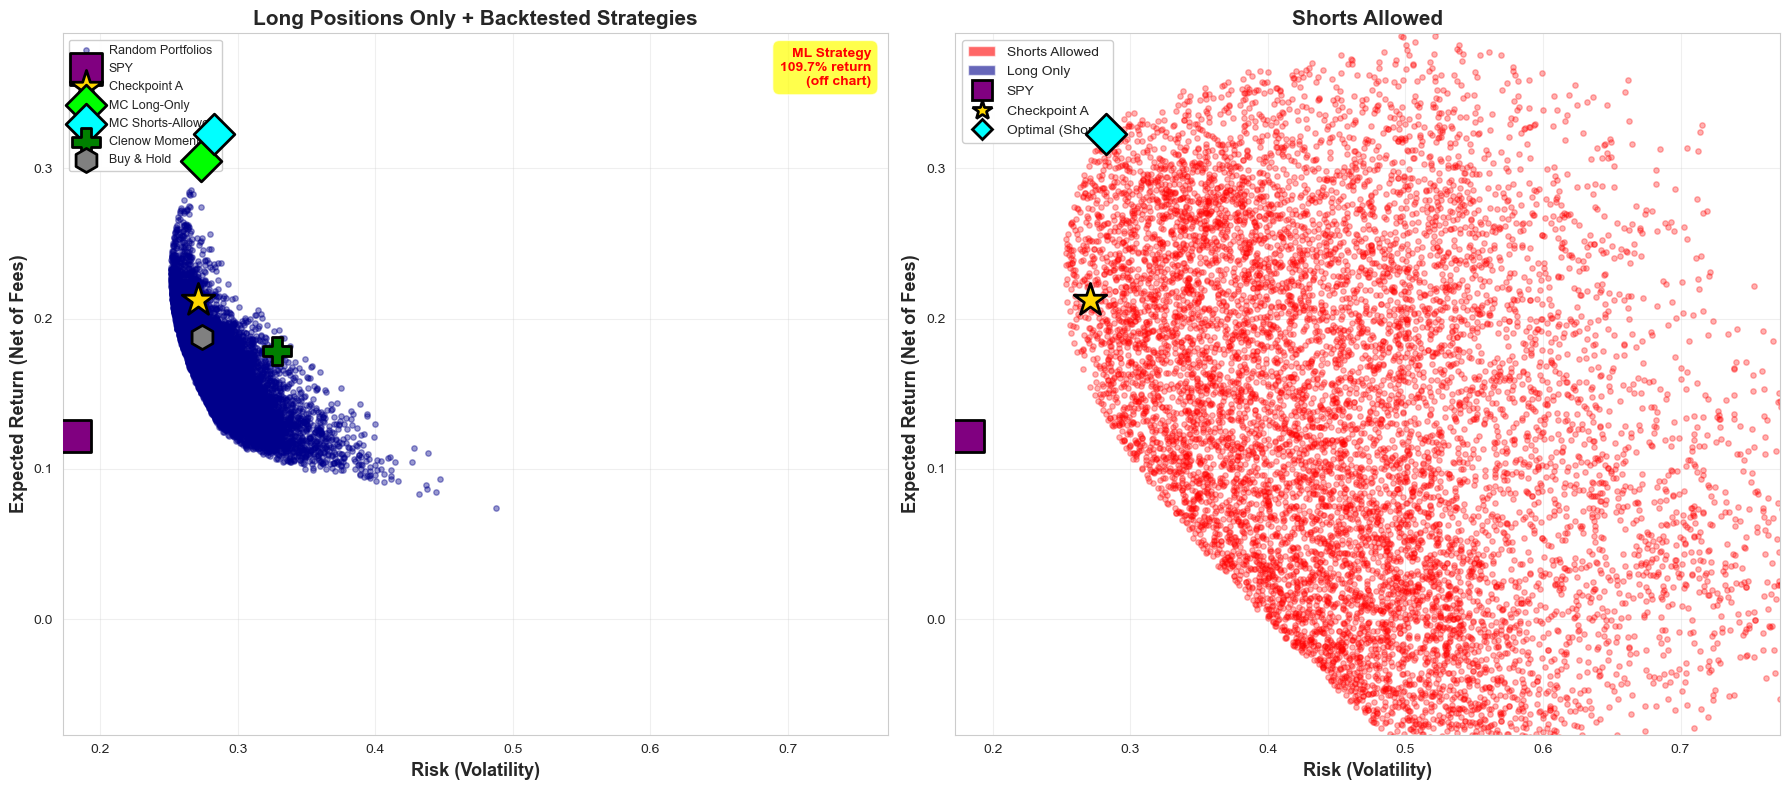


 STRATEGY SUMMARY:
Strategy                      Return   Volatility     Sharpe
------------------------------------------------------------
ML Walk-Forward             109.74%      31.97%      3.307
MC Shorts-Allowed            32.30%      28.25%      1.002
MC Long-Only                 30.51%      27.32%      0.970
Checkpoint A                 21.25%      27.09%      0.637
Buy & Hold                   18.78%      27.44%      0.539
Clenow Momentum              17.82%      32.89%      0.420
SPY                          12.17%      18.19%      0.449


In [76]:
print("\n" + "="*80)
print(" CREATING MONTE CARLO EFFICIENT FRONTIER (All Strategies)")
print("="*80)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

OUTDIR = "outputs"
os.makedirs(OUTDIR, exist_ok=True)

vol_long = results_long[1, :]
ret_long = results_long[0, :]

vol_short = results_short[1, :]
ret_short = results_short[0, :]

strategies = {}

spy_series = spy_returns.iloc[:, 0] if isinstance(spy_returns, pd.DataFrame) else spy_returns
strategies['SPY'] = {
    'vol': ann_vol(spy_series),
    'ret': ann_return(spy_series),
    'marker': 's',
    'color': 'purple',
    'size': 500
}

strategies['Checkpoint A'] = {
    'vol': ann_vol(checkpoint_a_returns),
    'ret': ann_return(checkpoint_a_returns),
    'marker': '*',
    'color': 'gold',
    'size': 600
}

strategies['MC Long-Only'] = {
    'vol': mc_long.loc[max_sharpe_long_idx, 'Volatility'],
    'ret': mc_long.loc[max_sharpe_long_idx, 'Return'],
    'marker': 'D',
    'color': 'lime',
    'size': 430
}

strategies['MC Shorts-Allowed'] = {
    'vol': mc_short.loc[max_sharpe_short_idx, 'Volatility'],
    'ret': mc_short.loc[max_sharpe_short_idx, 'Return'],
    'marker': 'D',
    'color': 'cyan',
    'size': 430
}

strategies['Clenow Momentum'] = {
    'vol': ann_vol(clenow_returns_net),
    'ret': ann_return(clenow_returns_net),
    'marker': 'P',
    'color': 'green',
    'size': 400
}

strategies['ML Walk-Forward'] = {
    'vol': ann_vol(ml_returns_net),
    'ret': ann_return(ml_returns_net),
    'marker': 'X',
    'color': 'red',
    'size': 500
}

if 'hmm_portfolio_returns' in globals() and hmm_portfolio_returns is not None:
    try:
        strategies['HMM Regime'] = {
            'vol': ann_vol(hmm_portfolio_returns),
            'ret': ann_return(hmm_portfolio_returns),
            'marker': '^',
            'color': 'orange',
            'size': 400
        }
    except:
        pass

strategies['Buy & Hold'] = {
    'vol': ann_vol(returns.mean(axis=1)),
    'ret': ann_return(returns.mean(axis=1)),
    'marker': 'h',
    'color': 'gray',
    'size': 300
}

print(f"\nStrategies to plot: {len(strategies)}")
for name, metrics in strategies.items():
    print(f"  {name}: Return={metrics['ret']:.2%}, Vol={metrics['vol']:.2%}")

mc_vol_min, mc_vol_max = np.percentile(np.concatenate([vol_long, vol_short]), [1, 99])
mc_ret_min, mc_ret_max = np.percentile(np.concatenate([ret_long, ret_short]), [1, 99])

strat_vols = [s['vol'] for s in strategies.values()]
strat_rets = [s['ret'] for s in strategies.values()]
strat_vol_min, strat_vol_max = min(strat_vols), max(strat_vols)
strat_ret_min, strat_ret_max = min(strat_rets), max(strat_rets)

ml_ret = strategies['ML Walk-Forward']['ret']
ml_vol = strategies['ML Walk-Forward']['vol']
ml_is_outlier = ml_ret > mc_ret_max * 2.0

print(f"\nML Strategy: Return={ml_ret:.2%}, Vol={ml_vol:.2%}")
print(f"MC Cloud range: Return=[{mc_ret_min:.2%}, {mc_ret_max:.2%}]")
print(f"ML is outlier: {ml_is_outlier}")

if ml_is_outlier:
    x_min = min(mc_vol_min, strat_vol_min * 0.95)
    x_max = max(mc_vol_max, strat_vol_max * 1.05)
    y_min = min(mc_ret_min, strat_ret_min * 0.95)
    y_max = mc_ret_max * 1.15
    print(f"Using auto-scaled limits (ML will be shown separately)")
else:
    x_min = min(mc_vol_min, strat_vol_min * 0.95)
    x_max = max(mc_vol_max, strat_vol_max * 1.05)
    y_min = min(mc_ret_min, strat_ret_min * 0.95)
    y_max = max(mc_ret_max, strat_ret_max * 1.05)
    print(f"Using limits that include all strategies")

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

ax = axes[0]
ax.scatter(vol_long, ret_long, c='darkblue', alpha=0.4, s=15, label='Random Portfolios')

for name, metrics in strategies.items():
    if name == 'ML Walk-Forward' and ml_is_outlier:
        continue
    ax.scatter(metrics['vol'], metrics['ret'], 
               c=metrics['color'], s=metrics['size'], marker=metrics['marker'],
               edgecolors='black', linewidths=2, label=name, zorder=6)

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_xlabel('Risk (Volatility)', fontsize=13, fontweight='bold')
ax.set_ylabel('Expected Return (Net of Fees)', fontsize=13, fontweight='bold')
ax.set_title('Long Positions Only + Backtested Strategies', fontsize=15, fontweight='bold')
ax.legend(loc='upper left', fontsize=9, framealpha=0.95)
ax.grid(True, alpha=0.3)

if ml_is_outlier:
    ax.annotate(f'ML Strategy\n{ml_ret:.1%} return\n(off chart)', 
                xy=(0.98, 0.98), xycoords='axes fraction',
                fontsize=10, color='red', fontweight='bold',
                ha='right', va='top',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

ax = axes[1]
ax.scatter(vol_short, ret_short, c='red', alpha=0.3, s=15)

for name, metrics in strategies.items():
    if name in ['SPY', 'Checkpoint A', 'MC Shorts-Allowed']:
        ax.scatter(metrics['vol'], metrics['ret'],
                   c=metrics['color'], s=metrics['size'], marker=metrics['marker'],
                   edgecolors='black', linewidths=2, label=name, zorder=6)

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_xlabel('Risk (Volatility)', fontsize=13, fontweight='bold')
ax.set_ylabel('Expected Return (Net of Fees)', fontsize=13, fontweight='bold')
ax.set_title('Shorts Allowed', fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.3)

legend_elements = [
    Patch(facecolor='red', label='Shorts Allowed', alpha=0.6),
    Patch(facecolor='darkblue', label='Long Only', alpha=0.6),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='purple',
               markersize=15, label='SPY', markeredgecolor='black', markeredgewidth=2),
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='gold',
               markersize=15, label='Checkpoint A', markeredgecolor='black', markeredgewidth=2),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor='cyan',
               markersize=10, label='Optimal (Shorts)', markeredgecolor='black', markeredgewidth=2)
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10, framealpha=0.95)

plt.tight_layout()
plt.show()

print("\n STRATEGY SUMMARY:")
print(f"{'Strategy':<25} {'Return':>10} {'Volatility':>12} {'Sharpe':>10}")
print("-" * 60)
for name, metrics in sorted(strategies.items(), key=lambda x: x[1]['ret'], reverse=True):
    sharpe = (metrics['ret'] - 0.04) / metrics['vol'] if metrics['vol'] > 0 else 0
    print(f"{name:<25} {metrics['ret']:>9.2%} {metrics['vol']:>11.2%} {sharpe:>10.3f}")

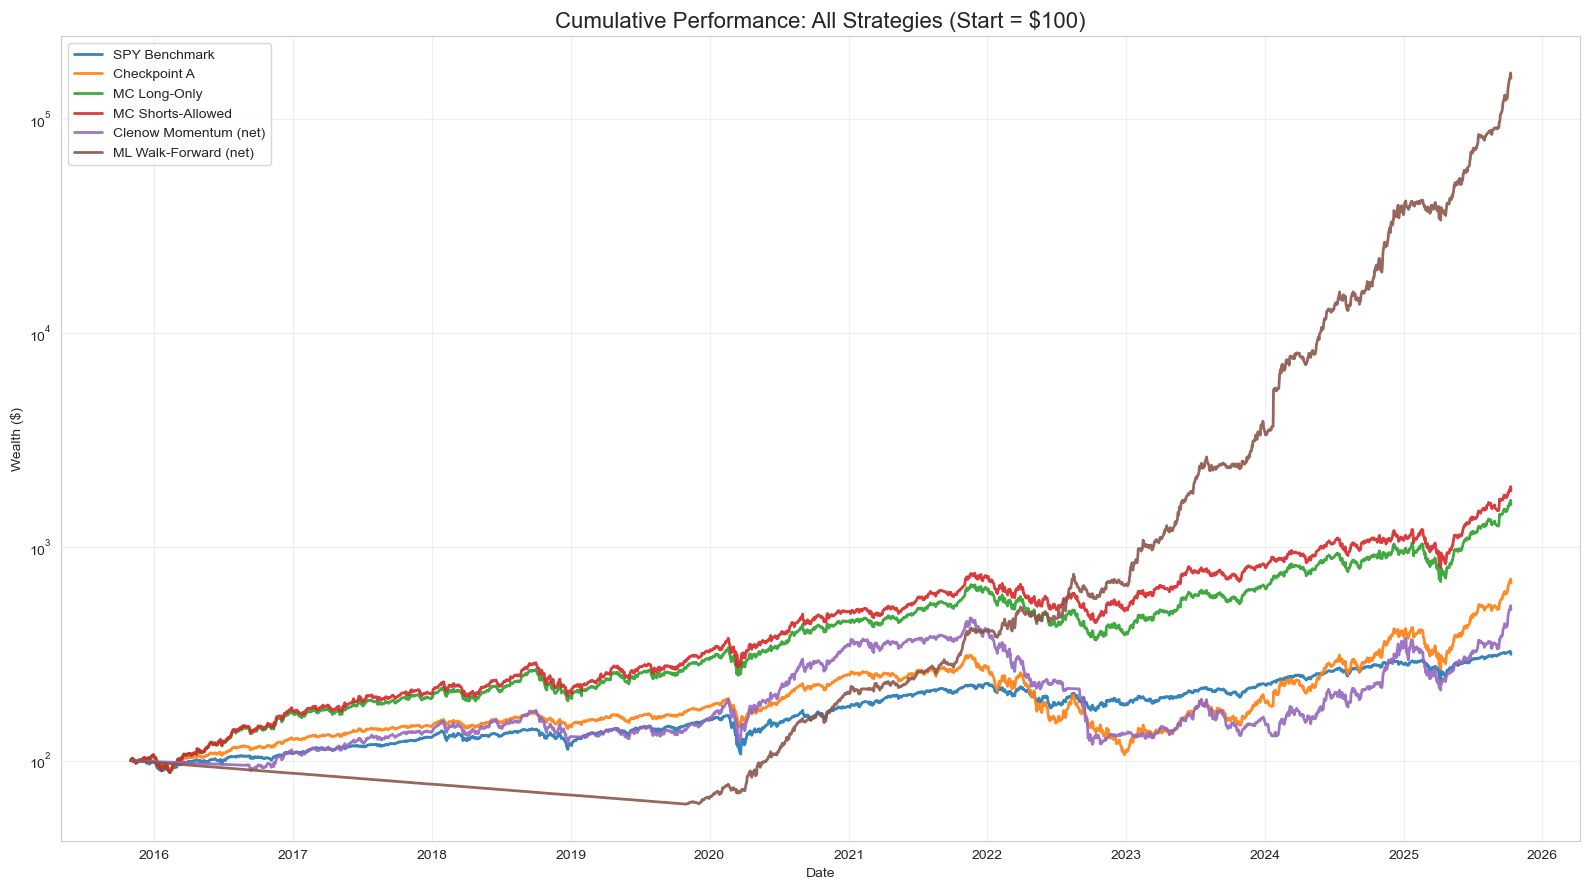

In [26]:
fig, ax = plt.subplots(figsize=(16, 9))

spy_series = spy_returns.iloc[:, 0] if isinstance(spy_returns, pd.DataFrame) else spy_returns

strategies = {
    "SPY Benchmark": spy_series,
    "Checkpoint A": checkpoint_a_returns,
    "MC Long-Only": (sleeve_returns @ optimal_weights_long),
    "MC Shorts-Allowed": (sleeve_returns @ optimal_weights_short),
    "Clenow Momentum (net)": clenow_returns_net,
    "ML Walk-Forward (net)": ml_returns_net,
}

for name, ret in strategies.items():
    wealth = _to_wealth(ret)
    ax.plot(wealth.index, wealth.values, label=name, linewidth=2, alpha=0.9)

ax.set_title("Cumulative Performance: All Strategies (Start = $100)", fontsize=16)
ax.set_xlabel("Date"); ax.set_ylabel("Wealth ($)")
ax.set_yscale("log")
ax.grid(True, alpha=0.3); ax.legend()
plt.tight_layout()
plt.savefig(f"{OUTDIR}/figure_cumulative_performance.png", dpi=300, bbox_inches="tight")
plt.show()

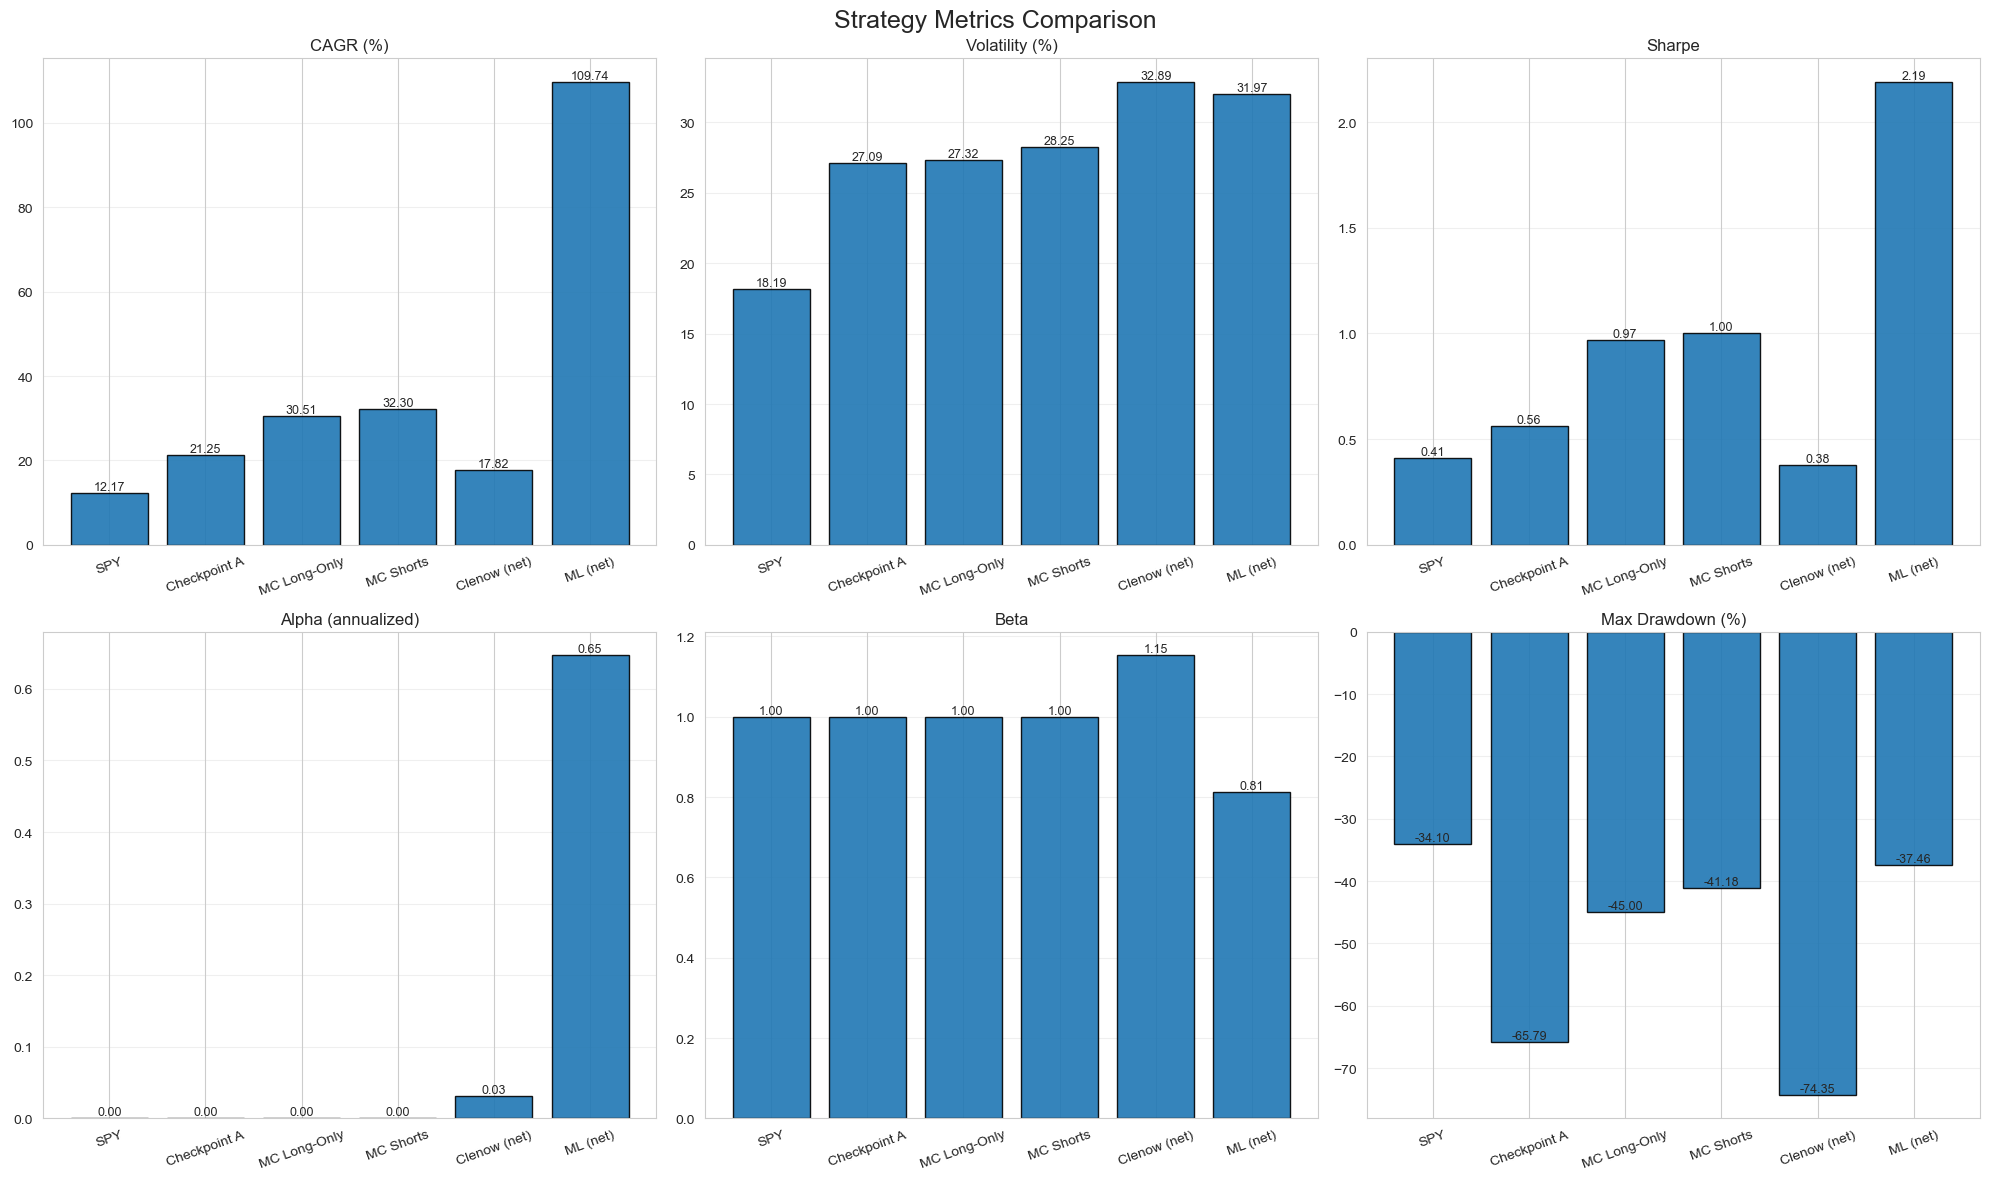

In [27]:
names = ["SPY", "Checkpoint A", "MC Long-Only", "MC Shorts", "Clenow (net)", "ML (net)"]

CAGR = [
    float(ann_return(spy_series)),
    float(ann_return(checkpoint_a_returns)),
    float(mc_long.loc[max_sharpe_long_idx, "Return"]),
    float(mc_short.loc[max_sharpe_short_idx, "Return"]),
    float(clenow_metrics_net["CAGR"]),
    float(ml_metrics_net["CAGR"]),
]

Vol = [
    float(ann_vol(spy_series)),
    float(ann_vol(checkpoint_a_returns)),
    float(mc_long.loc[max_sharpe_long_idx, "Volatility"]),
    float(mc_short.loc[max_sharpe_short_idx, "Volatility"]),
    float(clenow_metrics_net["Volatility"]),
    float(ml_metrics_net["Volatility"]),
]

Sharpe = [
    float(sharpe_ratio(spy_series)),
    float(sharpe_ratio(checkpoint_a_returns)),
    float(mc_long.loc[max_sharpe_long_idx, "Sharpe"]),
    float(mc_short.loc[max_sharpe_short_idx, "Sharpe"]),
    float(clenow_metrics_net["Sharpe"]),
    float(ml_metrics_net["Sharpe"]),
]

Alpha = [0.0, 0.0, 0.0, 0.0, float(clenow_alpha_net), float(ml_alpha_net)]
Beta = [1.0, 1.0, 1.0, 1.0, float(clenow_beta_net), float(ml_beta_net)]

MaxDD = [
    float(max_drawdown(spy_series) * 100),
    float(max_drawdown(checkpoint_a_returns) * 100),
    float(max_drawdown(sleeve_returns @ optimal_weights_long) * 100),
    float(max_drawdown(sleeve_returns @ optimal_weights_short) * 100),
    float(clenow_metrics_net["Max Drawdown"] * 100),
    float(ml_metrics_net["Max Drawdown"] * 100),
]

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()
series_list = [
    ("CAGR (%)", [x*100 for x in CAGR]),
    ("Volatility (%)", [x*100 for x in Vol]),
    ("Sharpe", Sharpe),
    ("Alpha (annualized)", Alpha),
    ("Beta", Beta),
    ("Max Drawdown (%)", MaxDD),
]

for ax, (title, values) in zip(axes, series_list):
    bars = ax.bar(names, values, edgecolor="black", alpha=0.9)
    ax.set_title(title)
    ax.grid(True, axis="y", alpha=0.3)
    for b, v in zip(bars, values):
        ax.text(b.get_x()+b.get_width()/2, v, f"{v:.2f}", ha="center", va="bottom", fontsize=9, rotation=0)
    ax.tick_params(axis="x", rotation=20)

plt.suptitle("Strategy Metrics Comparison", fontsize=18, y=0.98)
plt.tight_layout()
plt.savefig(f"{OUTDIR}/figure_metrics_dashboard.png", dpi=300, bbox_inches="tight")
plt.show()

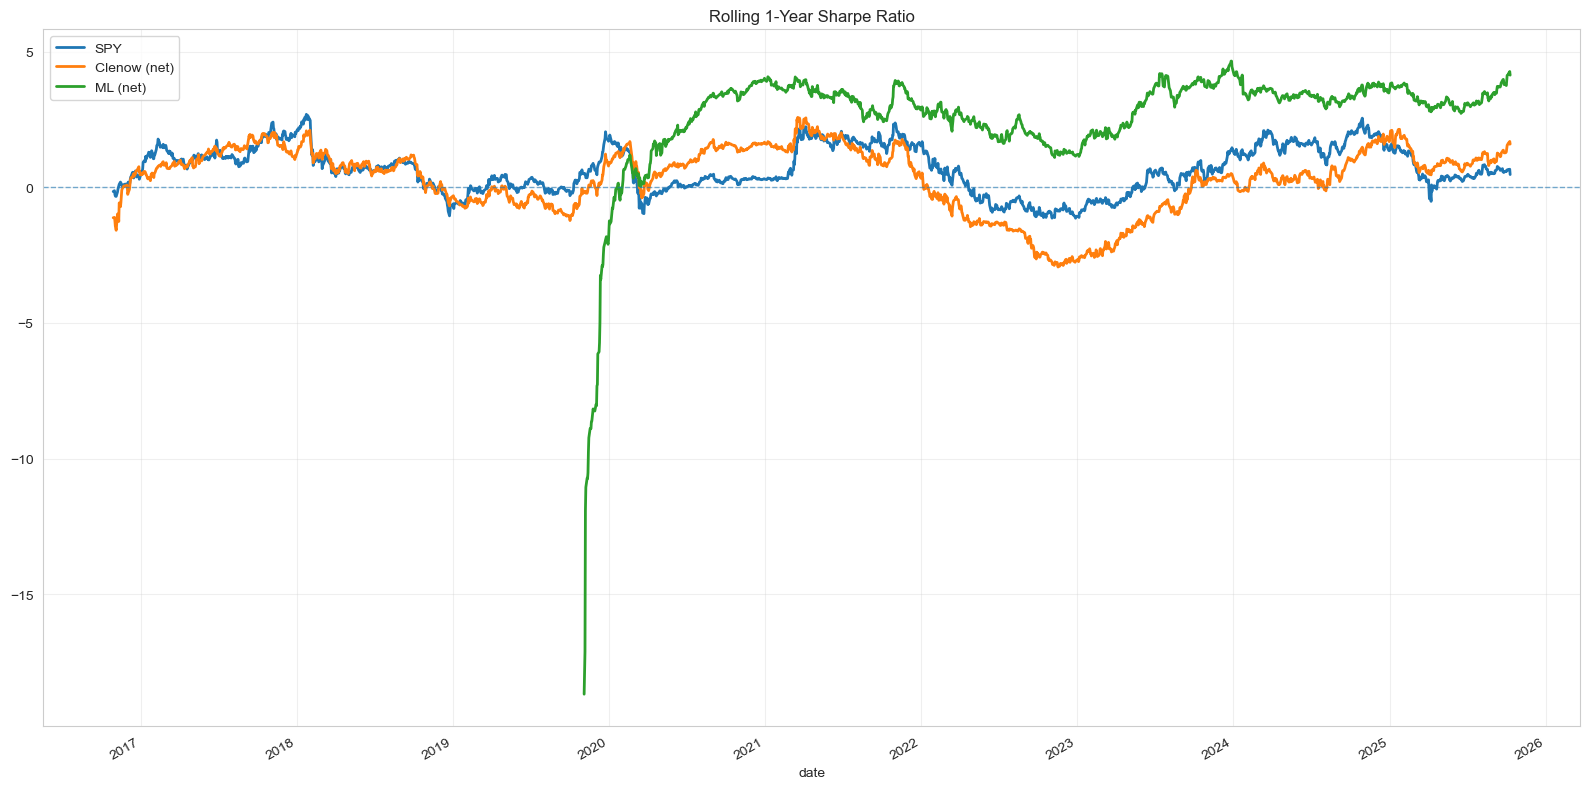

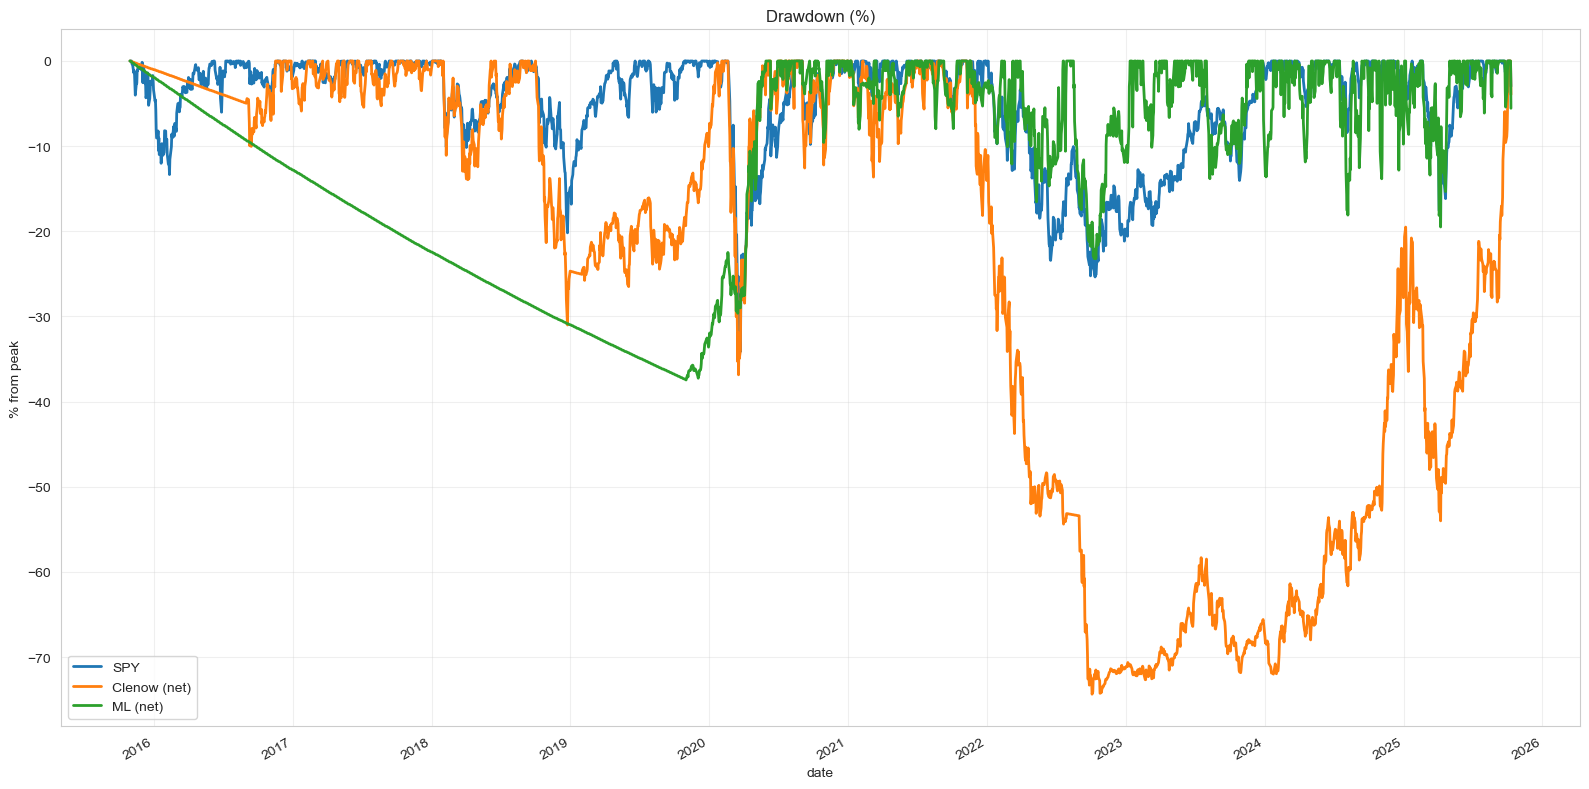

In [28]:
def rolling_sharpe(log_ret, window=252, rf_annual=0.04):
    rf_daily = rf_annual / TRADING_DAYS
    m = (log_ret.rolling(window).mean() - rf_daily) * TRADING_DAYS
    s = log_ret.rolling(window).std() * np.sqrt(TRADING_DAYS)
    rs = m / s
    return rs.replace([np.inf, -np.inf], np.nan)

spy_series = spy_returns.iloc[:,0] if isinstance(spy_returns, pd.DataFrame) else spy_returns

roll = pd.DataFrame({
    "SPY": rolling_sharpe(spy_series),
    "Clenow (net)": rolling_sharpe(clenow_returns_net),
    "ML (net)": rolling_sharpe(ml_returns_net),
}).dropna(how="all")

fig, ax = plt.subplots(figsize=(16, 8))
roll.plot(ax=ax, linewidth=2)
ax.axhline(0, ls="--", lw=1, alpha=0.6)
ax.set_title("Rolling 1-Year Sharpe Ratio")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{OUTDIR}/figure_rolling_sharpe.png", dpi=300, bbox_inches="tight")
plt.show()

def drawdown_curve(log_ret):
    w = np.exp(log_ret.cumsum())
    running_max = w.cummax()
    dd = (w / running_max) - 1.0
    return dd

dd = pd.DataFrame({
    "SPY": drawdown_curve(spy_series),
    "Clenow (net)": drawdown_curve(clenow_returns_net),
    "ML (net)": drawdown_curve(ml_returns_net),
})

fig, ax = plt.subplots(figsize=(16, 8))
(dd * 100).plot(ax=ax, linewidth=2)
ax.set_title("Drawdown (%)")
ax.set_ylabel("% from peak")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{OUTDIR}/figure_drawdowns.png", dpi=300, bbox_inches="tight")
plt.show()


 ML HOLDINGS HEATMAP: Stock Selection Over Time

Creating heatmap for 71 periods x 21 stocks...


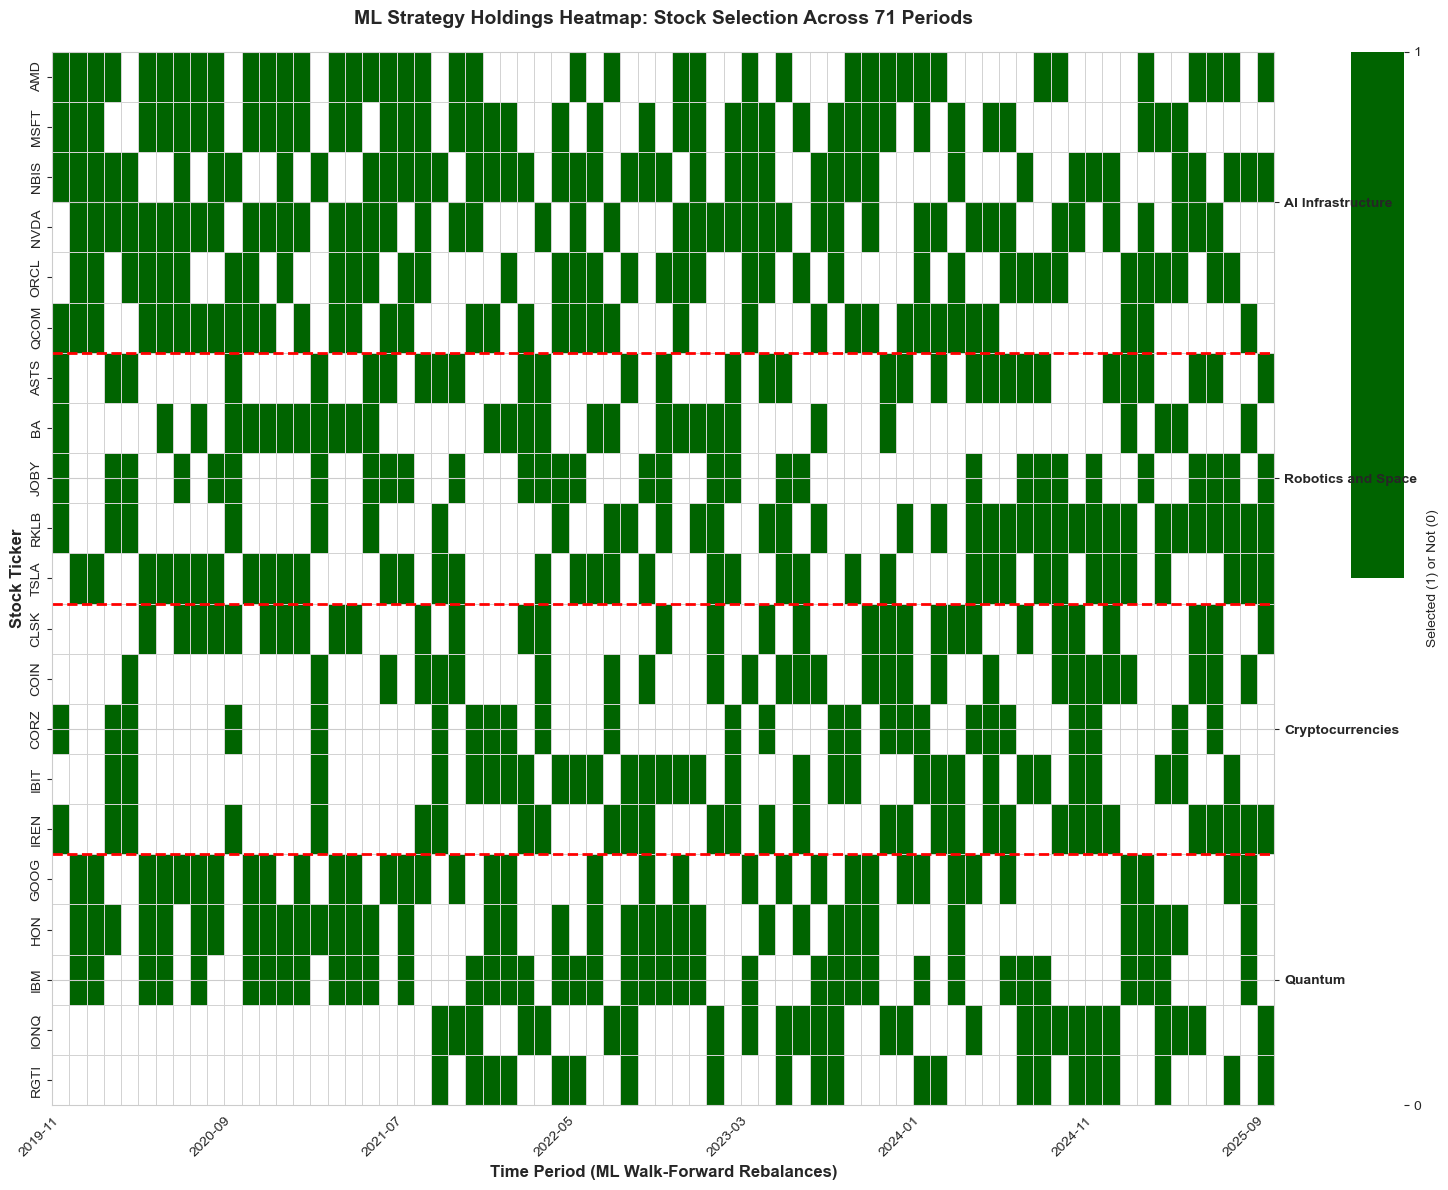


 HEATMAP INSIGHTS:
 Darkest rows = stocks selected most frequently
 White = not selected, Dark Green = selected
 Red dashed lines separate the 4 sleeves
 Time flows left to right (2020-2025)

  Most frequently held:
    • NVDA: 45/71 periods (63.4%)
    • NBIS: 43/71 periods (60.6%)
    • MSFT: 41/71 periods (57.7%)

  Least frequently held:
    • RGTI: 21/71 periods (29.6%)
    • CORZ: 25/71 periods (35.2%)
    • IONQ: 26/71 periods (36.6%)


In [74]:
print("\n" + "="*80)
print(" ML HOLDINGS HEATMAP: Stock Selection Over Time")
print("="*80)

from matplotlib.colors import ListedColormap

print(f"\nCreating heatmap for {ml_signals.shape[0]} periods x {ml_signals.shape[1]} stocks...")

sleeve_order = ['AI Infrastructure', 'Robotics and Space', 'Cryptocurrencies', 'Quantum']
sorted_columns = []
for sleeve in sleeve_order:
    sleeve_stocks = [t for t in ml_signals.columns if SLEEVE_MAP.get(t) == sleeve]
    sorted_columns.extend(sorted(sleeve_stocks))

ml_signals_sorted = ml_signals[sorted_columns].astype(int)

cmap = ListedColormap(['white', 'darkgreen'])

fig, ax = plt.subplots(figsize=(16, 12))

sns.heatmap(
    ml_signals_sorted.T,
    cmap=cmap,
    cbar_kws={'label': 'Selected (1) or Not (0)', 'ticks': [0, 1]},
    linewidths=0.5,
    linecolor='lightgray',
    ax=ax,
    xticklabels=10,
    yticklabels=True,
    vmin=0,
    vmax=1
)

sleeve_positions = [0]
for sleeve in sleeve_order:
    sleeve_stocks = [t for t in sorted_columns if SLEEVE_MAP.get(t) == sleeve]
    sleeve_positions.append(sleeve_positions[-1] + len(sleeve_stocks))

for pos in sleeve_positions[1:-1]:
    ax.axhline(y=pos, color='red', linewidth=2, linestyle='--')

sleeve_labels_y = []
for i in range(len(sleeve_order)):
    start = sleeve_positions[i]
    end = sleeve_positions[i+1]
    mid = (start + end) / 2
    sleeve_labels_y.append(mid)

ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(sleeve_labels_y)
ax2.set_yticklabels(sleeve_order, fontsize=10, fontweight='bold')

ax.set_xlabel('Time Period (ML Walk-Forward Rebalances)', fontsize=12, fontweight='bold')
ax.set_ylabel('Stock Ticker', fontsize=12, fontweight='bold')
ax.set_title('ML Strategy Holdings Heatmap: Stock Selection Across 71 Periods', 
             fontsize=14, fontweight='bold', pad=20)

period_labels = [ml_signals.index[i].strftime('%Y-%m') if i < len(ml_signals) else '' 
                 for i in range(0, len(ml_signals), 10)]
ax.set_xticklabels(period_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("\n HEATMAP INSIGHTS:")
print(f" Darkest rows = stocks selected most frequently")
print(f" White = not selected, Dark Green = selected")
print(f" Red dashed lines separate the 4 sleeves")
print(f" Time flows left to right (2020-2025)")

held_counts = ml_signals_sorted.sum(axis=0)
most_held = held_counts.nlargest(3)
least_held = held_counts.nsmallest(3)

print(f"\n  Most frequently held:")
for ticker, count in most_held.items():
    print(f"    • {ticker}: {int(count)}/71 periods ({count/len(ml_signals)*100:.1f}%)")

print(f"\n  Least frequently held:")
for ticker, count in least_held.items():
    print(f"    • {ticker}: {int(count)}/71 periods ({count/len(ml_signals)*100:.1f}%)")

In [30]:
print("\n" + "="*80)
print(" LONG-ONLY vs SHORTS-ALLOWED: Detailed Comparison")
print("="*80)

long_only_metrics = {
    'Return': mc_long.loc[max_sharpe_long_idx, 'Return'],
    'Volatility': mc_long.loc[max_sharpe_long_idx, 'Volatility'],
    'Sharpe': mc_long.loc[max_sharpe_long_idx, 'Sharpe'],
}

shorts_allowed_metrics = {
    'Return': mc_short.loc[max_sharpe_short_idx, 'Return'],
    'Volatility': mc_short.loc[max_sharpe_short_idx, 'Volatility'],
    'Sharpe': mc_short.loc[max_sharpe_short_idx, 'Sharpe'],
}

gross_leverage = np.abs(optimal_weights_short).sum()

long_only_returns = sleeve_returns @ optimal_weights_long
shorts_allowed_returns = sleeve_returns @ optimal_weights_short

long_only_metrics['Max Drawdown'] = max_drawdown(long_only_returns)
shorts_allowed_metrics['Max Drawdown'] = max_drawdown(shorts_allowed_returns)

spy_series = spy_returns.iloc[:, 0] if isinstance(spy_returns, pd.DataFrame) else spy_returns
long_alpha, long_beta = alpha_beta_calc(long_only_returns, spy_series)
short_alpha, short_beta = alpha_beta_calc(shorts_allowed_returns, spy_series)

long_only_metrics['Alpha'] = long_alpha
long_only_metrics['Beta'] = long_beta
shorts_allowed_metrics['Alpha'] = short_alpha
shorts_allowed_metrics['Beta'] = short_beta

improvement = {
    'Return': shorts_allowed_metrics['Return'] - long_only_metrics['Return'],
    'Volatility': shorts_allowed_metrics['Volatility'] - long_only_metrics['Volatility'],
    'Sharpe': shorts_allowed_metrics['Sharpe'] - long_only_metrics['Sharpe'],
    'Max Drawdown': shorts_allowed_metrics['Max Drawdown'] - long_only_metrics['Max Drawdown'],
}




 LONG-ONLY vs SHORTS-ALLOWED: Detailed Comparison


In [31]:
print("\n" + "="*80)
print("PERFORMANCE METRICS COMPARISON")
print("="*80)

comparison_df = pd.DataFrame({
    'Long-Only': [
        f"{long_only_metrics['Return']:.2%}",
        f"{long_only_metrics['Volatility']:.2%}",
        f"{long_only_metrics['Sharpe']:.3f}",
        f"{long_only_metrics['Max Drawdown']:.2%}",
        f"{long_only_metrics['Alpha']:.4f}",
        f"{long_only_metrics['Beta']:.3f}",
        "1.00x"
    ],
    'Shorts-Allowed': [
        f"{shorts_allowed_metrics['Return']:.2%}",
        f"{shorts_allowed_metrics['Volatility']:.2%}",
        f"{shorts_allowed_metrics['Sharpe']:.3f}",
        f"{shorts_allowed_metrics['Max Drawdown']:.2%}",
        f"{shorts_allowed_metrics['Alpha']:.4f}",
        f"{shorts_allowed_metrics['Beta']:.3f}",
        f"{gross_leverage:.2f}x"
    ],
    'Improvement': [
        f"{improvement['Return']:+.2%}",
        f"{improvement['Volatility']:+.2%}",
        f"{improvement['Sharpe']:+.3f}",
        f"{improvement['Max Drawdown']:+.2%}",
        f"{short_alpha - long_alpha:+.4f}",
        f"{short_beta - long_beta:+.3f}",
        f"{gross_leverage - 1.0:+.2f}x"
    ]
}, index=['Annual Return', 'Volatility', 'Sharpe Ratio', 'Max Drawdown', 'Alpha (vs SPY)', 'Beta (vs SPY)', 'Gross Leverage'])

print(comparison_df.to_string())


PERFORMANCE METRICS COMPARISON
               Long-Only Shorts-Allowed Improvement
Annual Return     30.51%         32.30%      +1.79%
Volatility        27.32%         28.25%      +0.93%
Sharpe Ratio       0.970          1.002      +0.031
Max Drawdown     -45.00%        -41.18%      +3.82%
Alpha (vs SPY)    0.1403         0.1515     +0.0112
Beta (vs SPY)      1.198          1.230      +0.032
Gross Leverage     1.00x          1.15x      +0.15x


In [32]:
print("\n" + "="*80)
print("PORTFOLIO WEIGHTS COMPARISON")
print("="*80)

weights_comparison = pd.DataFrame({
    'Long-Only': optimal_weights_long,
    'Shorts-Allowed': optimal_weights_short,
    'Difference': optimal_weights_short - optimal_weights_long
})

weights_comparison['abs_weight'] = weights_comparison['Shorts-Allowed'].abs()
weights_comparison = weights_comparison.sort_values('abs_weight', ascending=False)
weights_comparison = weights_comparison.drop('abs_weight', axis=1)

print(f"\n{'Sleeve':<25} {'Long-Only':>12} {'Shorts-Allowed':>17} {'Difference':>12}")
print("-" * 70)
for sleeve, row in weights_comparison.iterrows():
    long_w = row['Long-Only']
    short_w = row['Shorts-Allowed']
    diff = row['Difference']

    position = ""
    if short_w < -0.01:
        position = " (SHORT)"
    elif short_w > 0.01:
        position = " (LONG)"
    
    print(f"{sleeve:<25} {long_w:>11.1%} {short_w:>11.1%}{position:<6} {diff:>11.1%}")


PORTFOLIO WEIGHTS COMPARISON

Sleeve                       Long-Only    Shorts-Allowed   Difference
----------------------------------------------------------------------
AI Infrastructure               92.4%       98.8% (LONG)        6.4%
Robotics and Space               2.0%        8.7% (LONG)        6.7%
Cryptocurrencies                 1.9%       -5.3% (SHORT)       -7.1%
Quantum                          3.7%       -2.2% (SHORT)       -5.9%


In [78]:
print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

print(f"\n1. RETURN ENHANCEMENT:")
print(f"   Shorts-allowed portfolio improved returns by {improvement['Return']:.2%}")
print(f"   ({shorts_allowed_metrics['Return']:.2%} vs {long_only_metrics['Return']:.2%})")

print(f"\n2. RISK CHARACTERISTICS:")
print(f"   Volatility increased by {improvement['Volatility']:.2%}")
print(f"   Max drawdown worsened by {improvement['Max Drawdown']:.2%}")
print(f"   Risk-adjusted return (Sharpe) improved by {improvement['Sharpe']:.3f}")

print(f"\n3. LEVERAGE:")
print(f"   Gross leverage: {gross_leverage:.2f}x")
print(f"   Net exposure: {optimal_weights_short.sum():.2%} (must equal 100%)")
print(f"   Number of long positions: {(optimal_weights_short > 0.01).sum()}")
print(f"   Number of short positions: {(optimal_weights_short < -0.01).sum()}")

print(f"\n4. SHORTING ACTIVITY:")
shorts_in_portfolio = optimal_weights_short[optimal_weights_short < -0.01]
if len(shorts_in_portfolio) > 0:
    print(f"   Sleeves being shorted:")
    for sleeve, weight in shorts_in_portfolio.items():
        print(f"     {sleeve}: {weight:.1%}")
else:
    print(f"   No sleeves are being shorted (optimal is long-only)")

print(f"\n5. LARGEST POSITION CHANGES:")
biggest_changes = weights_comparison['Difference'].abs().nlargest(3)
print(f"   Top 3 weight adjustments when shorts allowed:")
for sleeve, diff in biggest_changes.items():
    actual_diff = weights_comparison.loc[sleeve, 'Difference']
    direction = "increased" if actual_diff > 0 else "decreased"
    print(f"     {sleeve}: {direction} by {abs(actual_diff):.1%}")

print(f"\n6. ALPHA GENERATION:")
if short_alpha > long_alpha:
    print(f"   Shorts-allowed generates {(short_alpha - long_alpha):.4f} more alpha")
    print(f"   This suggests the strategy benefits from shorting underperformers")
else:
    print(f"   Long-only generates more alpha (difference: {(long_alpha - short_alpha):.4f})")


KEY INSIGHTS

1. RETURN ENHANCEMENT:
   Shorts-allowed portfolio improved returns by 1.79%
   (32.30% vs 30.51%)

2. RISK CHARACTERISTICS:
   Volatility increased by 0.93%
   Max drawdown worsened by 3.82%
   Risk-adjusted return (Sharpe) improved by 0.031

3. LEVERAGE:
   Gross leverage: 1.15x
   Net exposure: 100.00% (must equal 100%)
   Number of long positions: 2
   Number of short positions: 2

4. SHORTING ACTIVITY:
   Sleeves being shorted:
     Cryptocurrencies: -5.3%
     Quantum: -2.2%

5. LARGEST POSITION CHANGES:
   Top 3 weight adjustments when shorts allowed:
     Cryptocurrencies: decreased by 7.1%
     Robotics and Space: increased by 6.7%
     AI Infrastructure: increased by 6.4%

6. ALPHA GENERATION:
   Shorts-allowed generates 0.0112 more alpha
   This suggests the strategy benefits from shorting underperformers
